### imports, directories, load data

In [1]:
# general imports
import pickle
import numpy as np
import pandas as pd
import sys
import os
import copy
import pdb
import csv
import cv2
sys.path.append('../')  


# plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_rgba
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Patch


# stats imports
import scipy.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp, wilcoxon, ks_2samp, sem
from random import randint
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
import statsmodels.formula.api as smf


# custom imports
from general_utils import get_transient_timestamps_mod, calculate_auROC, significant_modulation_proportion, generate_labels_from_cv_filtered, calculate_auROC_with_permutation

In [2]:
figDataSaveDir = r"C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data"
dryadDir = 'C:/code/miniscope-analysis-mek/InterneuronInhibNAc/InterneuronInhibNAc/dryad/'

In [3]:
# Load the consolidated data
def load_all_variables(loadDir):
    file_path = loadDir + "\cell_encoding_total.pkl"
    with open(file_path, 'rb') as f:
        all_data = pickle.load(f)
    return all_data

# Load all variables
loaded_variables = load_all_variables(dryadDir)

# Access variables directly as before
data_groups_forBehav = loaded_variables["data_groups_forBehav"]
data_groups_d01 = loaded_variables["data_groups_d01"]
data_groups_d2 = loaded_variables["data_groups_d2"]
day0_1_auROCs = loaded_variables["day0_1_auROCs"]
day2_14_auROCs_partner = loaded_variables["day2_14_auROCs_partner"]
day2_14_auROCs_novel = loaded_variables["day2_14_auROCs_novel"]
preprocessed_stability_data = loaded_variables["preprocessed_stability_data"]
all_neuron_data = loaded_variables["all_neuron_data"]
overlap_stats = loaded_variables["overlap_stats"]
specific_neurons = loaded_variables["specific_neurons"]

### day 0/1 social intx time


Linear Mixed Model Results:
             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   Percentage
No. Observations:    36        Method:               REML      
No. Groups:          2         Scale:                366.3550  
Min. group size:     16        Log-Likelihood:       -148.2172 
Max. group size:     20        Converged:            Yes       
Mean group size:     18.0                                      
---------------------------------------------------------------
               Coef.     Std.Err.     z    P>|z|  [0.025 0.975]
---------------------------------------------------------------
Intercept      56.326        19.871  2.835 0.005  17.380 95.272
Group[T.expt]  -1.485        27.820 -0.053 0.957 -56.010 53.040
Day[T.day1]    10.980         6.380  1.721 0.085  -1.525 23.485
Group Var     366.355 812383272.682                            

Group[T.expt]: b = -1.49, p = 0.957
Day[T.day1]: b = 10.98, p = 0.085


C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\seaborn\categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


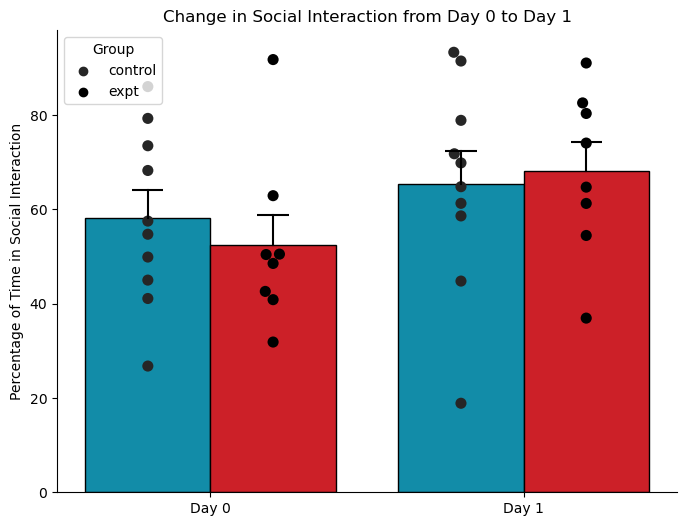

In [4]:
def calculate_social_interaction_percentages(data_groups_d01, behavior_label='Distance between [ 2 and 1 ] Less Than 50.00 mm'):
    results = {'control': {}, 'expt': {}}
    days = ['day0', 'day1']

    # Process each group and day
    for group_name, group_data in data_groups_d01.items():
        for animal_id, sessions in group_data.items():
            for day in days:
                if day in sessions:
                    cv_data = sessions[day]['cv']
                    total_time = cv_data['endInMs'].max()  # Total time from the end of the last recorded behavior
                    
                    # Filter events with partial matching of behavior label
                    filtered_data = cv_data[cv_data['EventType'] == behavior_label]
                    social_time = filtered_data['endInMs'].sub(filtered_data['startInMs']).sum()
                    
                    percentage = (social_time / total_time) * 100 if total_time > 0 else 0
                    
                    # Store percentage
                    if animal_id not in results[group_name]:
                        results[group_name][animal_id] = {}
                    results[group_name][animal_id][day] = percentage

    return results

def plot_average_social_interaction_changes_with_error(data_summary, save_dir, filename):
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)
    
    # Prepare data for CSV output
    csv_data = []
    for group, animals in data_summary.items():
        for animal, days in animals.items():
            for day, percentage in days.items():
                csv_data.append({'Group': group, 'Animal': animal, 'Day': day, 'Percentage': percentage})
    
    # Convert to DataFrame and save as CSV
    csv_df = pd.DataFrame(csv_data)
    csv_filename = os.path.join(save_dir, f"{filename}_data.csv")
    csv_df.to_csv(csv_filename, index=False)
    
    # Prepare data for plotting
    plot_data = []
    for group, animals in data_summary.items():
        for day in ['day0', 'day1']:
            day_percentages = [days[day] for animal, days in animals.items() if day in days]
            if day_percentages:
                for value in day_percentages:
                    plot_data.append({'Group': group, 'Day': day, 'Percentage': value})
    
    plot_df = pd.DataFrame(plot_data)
    
    # Fit a linear mixed model
    plot_df['Group'] = plot_df['Group'].astype('category')
    plot_df['Day'] = plot_df['Day'].astype('category')
    
    # Formula: Percentage ~ Group + Day + (1|Animal)
    model = smf.mixedlm("Percentage ~ Group + Day", plot_df, groups=plot_df["Group"])
    result = model.fit()
    
    # Print results for main effects
    print("\nLinear Mixed Model Results:")
    print(result.summary())
    for term in ['Group[T.expt]', 'Day[T.day1]']:
        beta = result.params[term]
        p_value = result.pvalues[term]
        print(f"{term}: b = {beta:.2f}, p = {p_value:.3f}")
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.swarmplot(x='Day', y='Percentage', hue='Group', data=plot_df, dodge=True, color='black', size=8, ax=ax)
    
    # Calculate means and standard errors
    means = plot_df.groupby(['Group', 'Day'])['Percentage'].mean()
    sems = plot_df.groupby(['Group', 'Day'])['Percentage'].sem()
    
    # Plot bars and error bars
    bar_width = 0.4
    group_offsets = {'control': -bar_width / 2, 'expt': bar_width / 2}
    for (group, day), mean in means.items():
        sem = sems.get((group, day), 0)
        color = '#128CA8' if group == 'control' else '#CC2028'
        day_index = 0 if day == 'day0' else 1
        x_position = day_index + group_offsets[group]
        
        # Bar plot
        ax.bar(x=x_position, height=mean, color=color, edgecolor='black', width=bar_width, zorder=2)
        
        # Error bars only above the bar
        if sem > 0:
            ax.plot([x_position, x_position], [mean, mean + sem], color='black', linewidth=1.5, zorder=3)
            ax.hlines(mean + sem, x_position - 0.05, x_position + 0.05, color='black', linewidth=1.5, zorder=3)
    
    # Customize plot
    ax.set_title('Change in Social Interaction from Day 0 to Day 1')
    ax.set_xlabel('')
    ax.set_ylabel('Percentage of Time in Social Interaction')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Day 0', 'Day 1'])
    ax.legend(title='Group', loc='upper left')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Save plot as SVG and PNG
    plot_filename = os.path.join(save_dir, f"{filename}.svg")
    plt.savefig(plot_filename, format='svg', bbox_inches='tight')
    plt.savefig(plot_filename.replace('.svg', '.png'), format='png', bbox_inches='tight')
    plt.show()
    plt.close()


social_interaction_data = calculate_social_interaction_percentages(data_groups_d01, behavior_label='Distance between [ 2 and 1 ] Less Than  50.00 mm')

plot_average_social_interaction_changes_with_error(social_interaction_data, save_dir=figDataSaveDir + '/imagingInhib_behavior', filename='day0_1_social_interaction_percentages')


### PPT chamber preference

In [5]:
event_type = ['Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030',
    'Social Contact [ 1 with 3 ] in Area Right while Joint Motion < 0.030']

In [6]:
def calculate_chamber_preference(data, days=['day2', 'day14'], preference_type='partner'):
    results = {'control': {}, 'expt': {}}
    for group_name, group_data in data.items():
        for animal_id, sessions in group_data.items():
            for day in days:
                if day in sessions and 'partner_side' in sessions[day]:
                    cv = sessions[day]['cv']
                    side = sessions[day]['partner_side']
                    
                    if side:
                        if preference_type == 'novel':
                            # For novel preference, use the opposite side
                            side = 'left' if side == 'right' else 'right'
                        # Define event types based on the side for chamber time
                        event_type = f'Area:Mouse 1 Center In {side.capitalize()} chamber'
                        
                        # Calculate time spent in the chosen chamber
                        chosen_chamber_time = cv[cv['EventType'] == event_type]['endInMs'].sub(cv['startInMs']).sum()
                        
                        # Calculate total experiment time
                        total_experiment_time = cv['endInMs'].max()
                        
                        # Calculate the preference score as the percentage of total experiment time spent in the chosen chamber
                        chamber_percentage = (chosen_chamber_time / total_experiment_time) * 100 if total_experiment_time > 0 else 0
                        
                        if animal_id not in results[group_name]:
                            results[group_name][animal_id] = {}
                        results[group_name][animal_id][day] = chamber_percentage
                else:
                    print(f"Missing data or partner_side for {animal_id} on {day}, skipping.")
                    
    return results

def plot_chamber_preferences_day2(partner_results, novel_results, save_dir, filename):
    def extract_data(results, group, day='day2'):
        return [animal_data[day] for animal_data in results[group].values() if day in animal_data]

    def plot_comparison(control_data, expt_data, title, ylabel, set_ylim=None, filename_suffix=''):
        colors = {'Control': '#128CA8', 'Expt': '#CC2028'}
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Prepare data for swarmplot
        df = pd.DataFrame({
            'Group': ['Control'] * len(control_data) + ['Expt'] * len(expt_data),
            'Value': list(control_data) + list(expt_data)
        })
        
        # Save plot data to CSV
        csv_output = pd.DataFrame({'Control': pd.Series(control_data), 'Expt': pd.Series(expt_data)})
        csv_filename = os.path.join(save_dir, f"{filename}_{filename_suffix}_data.csv")
        csv_output.to_csv(csv_filename, index=False)
        
        # Plot individual data points in black
        sns.swarmplot(x='Group', y='Value', data=df, color='black', size=8, ax=ax)
        
        # Calculate means and standard errors
        mean_control = np.mean(control_data)
        mean_expt = np.mean(expt_data)
        se_control = stats.sem(control_data) if len(control_data) > 1 else 0
        se_expt = stats.sem(expt_data) if len(expt_data) > 1 else 0
        
        # Plot bars with black outline
        ax.bar(x=0, height=mean_control, color=colors['Control'], edgecolor='black', width=0.4, zorder=2)
        ax.bar(x=1, height=mean_expt, color=colors['Expt'], edgecolor='black', width=0.4, zorder=2)
        
        # Add SEM lines with horizontal ticks only above the bar
        if se_control > 0:
            ax.plot([0, 0], [mean_control, mean_control + se_control], color='black', linewidth=1.5, zorder=3)
            ax.hlines(mean_control + se_control, -0.05, 0.05, color='black', linewidth=1.5, zorder=3)
        if se_expt > 0:
            ax.plot([1, 1], [mean_expt, mean_expt + se_expt], color='black', linewidth=1.5, zorder=3)
            ax.hlines(mean_expt + se_expt, 0.95, 1.05, color='black', linewidth=1.5, zorder=3)
        
        # Perform statistical test
        t_stat, p_value = stats.ttest_ind(control_data, expt_data, equal_var=False)
        df_value = len(control_data) + len(expt_data) - 2
        print(f't({df_value}) = {t_stat:.2f}, p = {p_value:.4f}')
        
        # Set title and labels
        ax.set_title(title)
        ax.set_xlabel('')
        ax.set_ylabel(ylabel)
        
        # Set axis limits
        ax.set_xlim(-0.5, 1.5)
        if set_ylim is not None:
            ax.set_ylim(set_ylim)
            
        # Set x-axis labels
        ax.set_xticklabels(['Control', 'Expt'])
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Make remaining spines black
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        
        # Ensure ticks are only on the bottom and left
        ax.tick_params(top=False, right=False)
        
        # Save and show the plot
        save_path = os.path.join(save_dir, f"{filename}_{filename_suffix}")
        plt.savefig(f"{save_path}.svg", format='svg', bbox_inches='tight')
        plt.savefig(f"{save_path}.png", format='png', bbox_inches='tight')
        plt.show()

    def plot_partner_novel_comparison(control_partner, control_novel, expt_partner, expt_novel, save_dir, filename):
        import statsmodels.api as sm
        from statsmodels.regression.mixed_linear_model import MixedLM
        colors = {'Control': '#128CA8', 'Expt': '#CC2028'}
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Prepare data for mixed model and plotting
        n_control = len(control_partner)
        n_expt = len(expt_partner)
        
        data = {
            'Value': control_partner + control_novel + expt_partner + expt_novel,
            'Group': ['Control'] * n_control * 2 + ['Expt'] * n_expt * 2,
            'Type': ['Partner'] * n_control + ['Novel'] * n_control + 
                   ['Partner'] * n_expt + ['Novel'] * n_expt,
            'Subject': ['Control_'+str(i) for i in range(n_control)]*2 + 
                      ['Expt_'+str(i) for i in range(n_expt)]*2
        }
        df = pd.DataFrame(data)
        
        # Create effect-coded variables
        df['Drug_code'] = (df['Group'] == 'Expt').astype(int)*2 - 1
        df['Type_code'] = (df['Type'] == 'Novel').astype(int)*2 - 1
        df['Interaction'] = df['Drug_code'] * df['Type_code']
        
        # Fit mixed model
        model = MixedLM(df['Value'], 
                       sm.add_constant(df[['Drug_code', 'Type_code', 'Interaction']]),
                       groups=df['Subject'])
        results = model.fit()
        
        # Get coefficients (convert from effect coding to raw differences)
        drug_beta = float(results.params['Drug_code'] * 2)
        type_beta = float(results.params['Type_code'] * 2)
        interaction_beta = float(results.params['Interaction'] * 2)
        
        print("\nLinear Mixed Model Results:")
        print(f"Drug effect (IEM-1460 vs Vehicle): β = {drug_beta:.2f}, t({results.df_resid:.0f}) = {results.tvalues['Drug_code']:.2f}, p = {results.pvalues['Drug_code']:.4f}")
        print(f"Partner/Novel effect: β = {type_beta:.2f}, t({results.df_resid:.0f}) = {results.tvalues['Type_code']:.2f}, p = {results.pvalues['Type_code']:.4f}")
        print(f"Drug × Partner/Novel interaction: β = {interaction_beta:.2f}, t({results.df_resid:.0f}) = {results.tvalues['Interaction']:.2f}, p = {results.pvalues['Interaction']:.4f}\n")
        
        # Continue with plotting
        x_positions = [0, 1, 2, 3]
        x_labels = ['Control\nPartner', 'Control\nNovel', 'Expt\nPartner', 'Expt\nNovel']
        
        for i, (group, type_) in enumerate(zip(['Control', 'Control', 'Expt', 'Expt'], 
                                             ['Partner', 'Novel', 'Partner', 'Novel'])):
            group_data = df[(df['Group'] == group) & (df['Type'] == type_)]
            
            # Plot bar
            mean = group_data['Value'].mean()
            se = stats.sem(group_data['Value'])
            ax.bar(x_positions[i], mean, color=colors[group], alpha=0.7, width=0.8, edgecolor='black')
            
            # Add error bars
            if se > 0:
                ax.plot([x_positions[i], x_positions[i]], [mean, mean + se], color='black', linewidth=1.5)
                ax.hlines(mean + se, x_positions[i] - 0.05, x_positions[i] + 0.05, color='black', linewidth=1.5)
            
            # Plot individual data points
            sns.swarmplot(x=[x_positions[i]] * len(group_data), y='Value', data=group_data,
                         color='black', size=5, alpha=0.7)
        
        # Plot connecting lines for each animal
        for group, start_pos in zip(['Control', 'Expt'], [0, 2]):
            if group == 'Control':
                for p, n in zip(control_partner, control_novel):
                    ax.plot([start_pos, start_pos + 1], [p, n], color=colors[group], alpha=0.3)
            else:
                for p, n in zip(expt_partner, expt_novel):
                    ax.plot([start_pos, start_pos + 1], [p, n], color=colors[group], alpha=0.3)
        
        # Save mixed model results to stats file
        stats_filename = os.path.join(save_dir, f"{filename}_mixed_model_stats.txt")
        with open(stats_filename, 'w', encoding='utf-8') as f:
            f.write("Linear Mixed Model Results:\n\n")
            f.write(str(results.summary()) + "\n\n")
            f.write("\nFormatted Statistics:\n")
            f.write(f"Drug effect (IEM-1460 vs Vehicle): beta = {drug_beta:.2f}, t({results.df_resid:.0f}) = {results.tvalues['Drug_code']:.2f}, p = {results.pvalues['Drug_code']:.4f}\n")
            f.write(f"Partner/Novel effect: beta = {type_beta:.2f}, t({results.df_resid:.0f}) = {results.tvalues['Type_code']:.2f}, p = {results.pvalues['Type_code']:.4f}\n")
            f.write(f"Drug × Partner/Novel interaction: beta = {interaction_beta:.2f}, t({results.df_resid:.0f}) = {results.tvalues['Interaction']:.2f}, p = {results.pvalues['Interaction']:.4f}\n")
        
        # Customize plot
        ax.set_title('Partner vs Novel Chamber Time - Day 2')
        ax.set_ylabel('Chamber Time')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        ax.set_xlim(-1, 4)
        ax.set_ylim(0, 100)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend
        legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['Control'], alpha=0.7, label='Control'),
                         plt.Rectangle((0,0),1,1, facecolor=colors['Expt'], alpha=0.7, label='Expt')]
        ax.legend(handles=legend_elements, loc='upper right')
        
        # Save the plot
        save_path = os.path.join(save_dir, f"{filename}_partner_novel_comparison")
        plt.savefig(f"{save_path}.svg", format='svg', bbox_inches='tight')
        plt.savefig(f"{save_path}.png", format='png', bbox_inches='tight')
        plt.show()

    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)

    # Extract data
    control_partner = extract_data(partner_results, 'control')
    expt_partner = extract_data(partner_results, 'expt')
    control_novel = extract_data(novel_results, 'control')
    expt_novel = extract_data(novel_results, 'expt')
    
    # Original plots
    plot_comparison(control_partner, expt_partner, 
                   'Partner Preference - Day 2', 'Chamber Time', set_ylim=(0, 100), filename_suffix='partner')
    
    plot_comparison(control_novel, expt_novel, 
                   'Novel Preference - Day 2', 'Chamber Time', set_ylim=(0, 100), filename_suffix='novel')
    
    # Partner/(Partner+Novel)
    control_ratio = np.array(control_partner) / (np.array(control_partner) + np.array(control_novel))
    expt_ratio = np.array(expt_partner) / (np.array(expt_partner) + np.array(expt_novel))
    plot_comparison(control_ratio, expt_ratio, 
                   'Partner/(Partner+Novel) - Day 2', 'Ratio', set_ylim=(0, 1), filename_suffix='ratio')
    
    # New paired comparison plot with mixed model analysis
    plot_partner_novel_comparison(control_partner, control_novel, expt_partner, expt_novel, save_dir, filename)
    
    # Additional statistics
    t_stat_paired, p_value_paired = stats.ttest_rel(control_partner + expt_partner, control_novel + expt_novel)
    t_stat_control, p_value_control = stats.ttest_1samp(control_ratio, 0.5)
    t_stat_expt, p_value_expt = stats.ttest_1samp(expt_ratio, 0.5)

In [7]:
partner_chamber_results = calculate_chamber_preference(data_groups_forBehav)
novel_chamber_results = calculate_chamber_preference(data_groups_forBehav, preference_type='novel')


Missing data or partner_side for animal5 on day2, skipping.
Missing data or partner_side for animal8 on day2, skipping.
Missing data or partner_side for animal8 on day2, skipping.
Missing data or partner_side for animal5 on day2, skipping.
Missing data or partner_side for animal8 on day2, skipping.
Missing data or partner_side for animal8 on day2, skipping.


t(13) = 0.51, p = 0.6257


C:\Users\ephys\AppData\Local\Temp\ipykernel_27680\3124790952.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Control', 'Expt'])


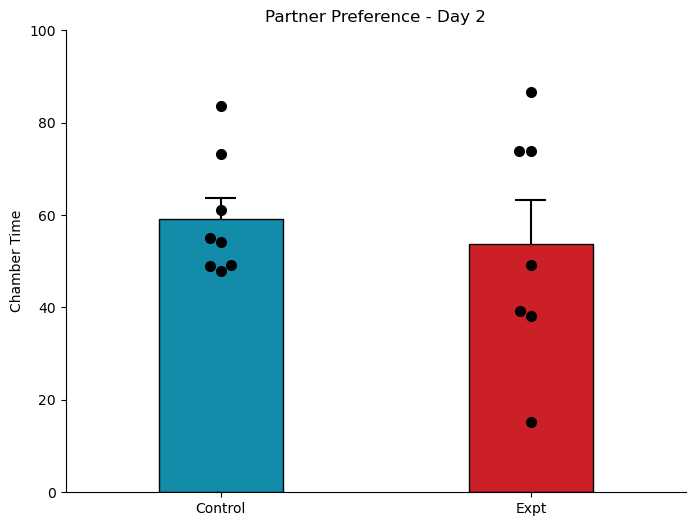

t(13) = 0.17, p = 0.8675


C:\Users\ephys\AppData\Local\Temp\ipykernel_27680\3124790952.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Control', 'Expt'])


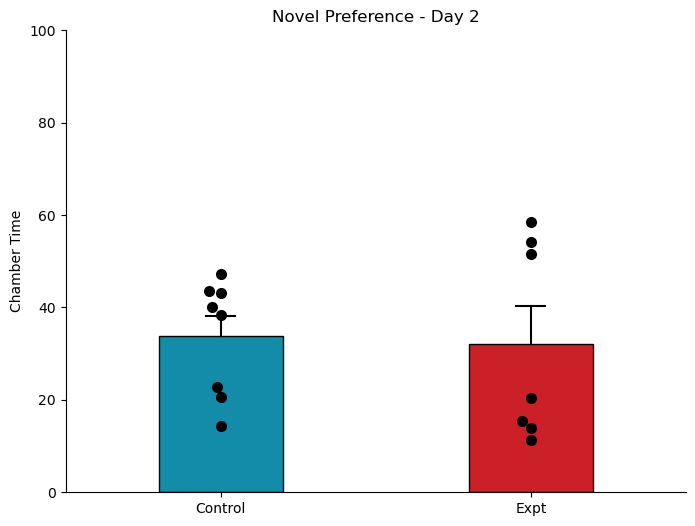

t(13) = 0.17, p = 0.8701


C:\Users\ephys\AppData\Local\Temp\ipykernel_27680\3124790952.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Control', 'Expt'])


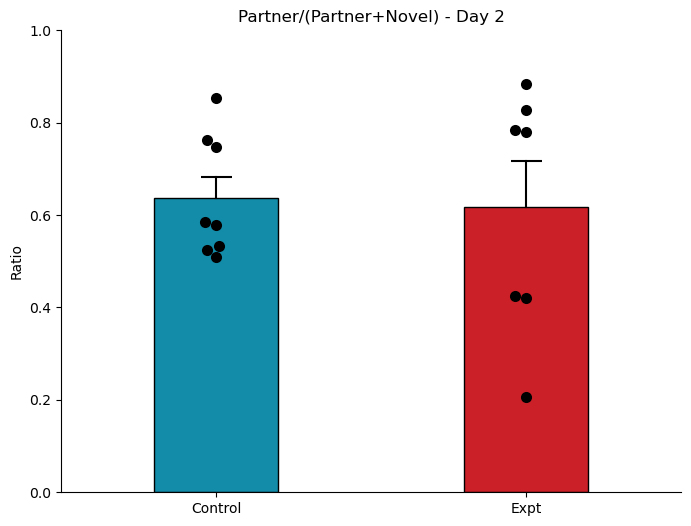

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge


Linear Mixed Model Results:
Drug effect (IEM-1460 vs Vehicle): β = -3.47, t(26) = -0.46, p = 0.6481
Partner/Novel effect: β = -23.47, t(26) = -3.50, p = 0.0005
Drug × Partner/Novel interaction: β = 1.89, t(26) = 0.28, p = 0.7776



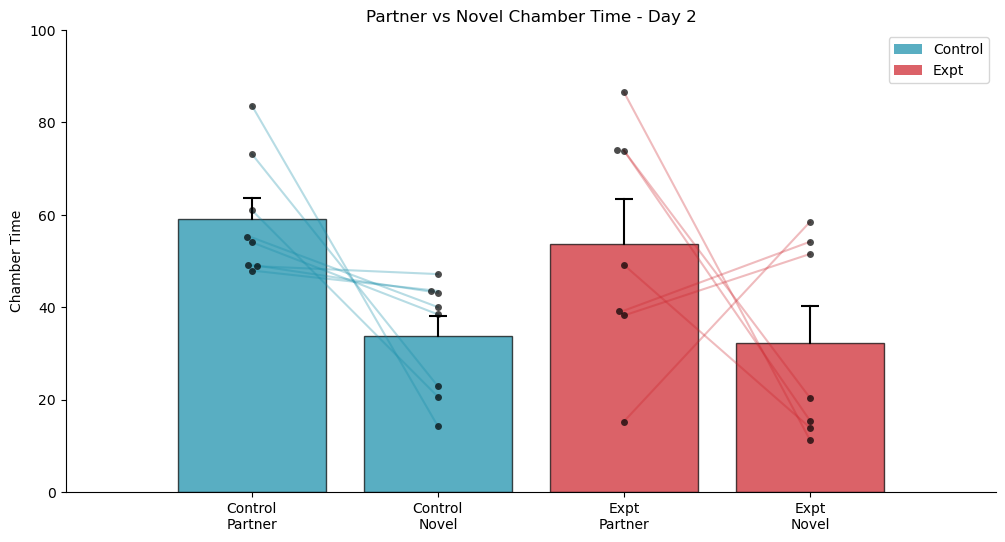

In [8]:
plot_chamber_preferences_day2(partner_chamber_results, novel_chamber_results, save_dir = figDataSaveDir + '/imagingInhib_behavior', filename='chamber_times')


Processing group: control
Animal animal1, Day day2: Partner Side: left, Matched Partner Events: 160, Matched Novel Events: 25
Animal animal2, Day day2: Partner Side: right, Matched Partner Events: 92, Matched Novel Events: 36
Animal animal3, Day day2: Partner Side: right, Matched Partner Events: 7, Matched Novel Events: 84
Animal animal4, Day day2: Partner Side: left, Matched Partner Events: 85, Matched Novel Events: 22
Animal animal5, Day day2: Missing session data. Skipping.
Animal animal6, Day day2: Partner Side: left, Matched Partner Events: 66, Matched Novel Events: 78
Animal animal7, Day day2: Partner Side: right, Matched Partner Events: 195, Matched Novel Events: 110
Animal animal8, Day day2: Missing session data. Skipping.
Animal animal9, Day day2: Partner Side: right, Matched Partner Events: 138, Matched Novel Events: 31
Animal animal10, Day day2: Partner Side: right, Matched Partner Events: 88, Matched Novel Events: 22
Processing group: expt
Animal animal1, Day day2: Partner 

C:\Users\ephys\AppData\Local\Temp\ipykernel_27680\563336269.py:119: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='Group', y='Score', data=df, palette=colors, size=8, ax=ax, dodge=True)


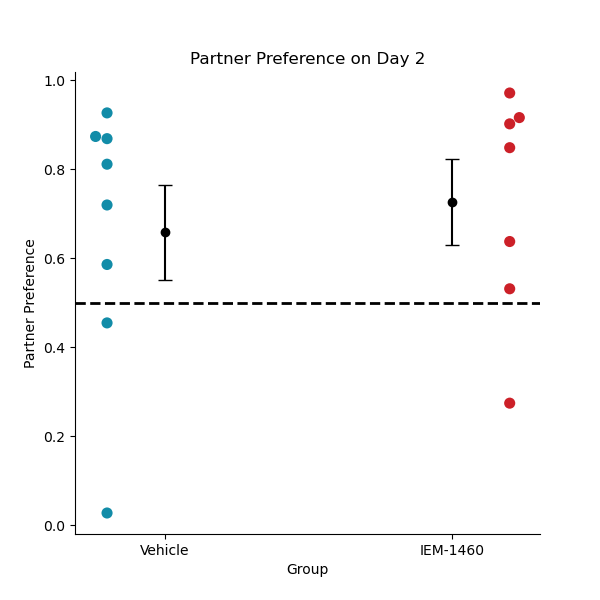

In [74]:
def calculate_partner_preference(data, days=['day2']):
    results = {'control': {}, 'expt': {}}
    huddle_times = {'control': {}, 'expt': {}}

    for group_name, group_data in data.items():
        print(f"Processing group: {group_name}")
        for animal_id, sessions in group_data.items():
            for day in days:
                if day in sessions:
                    cv = sessions[day]['cv']
                    partner_side = sessions[day].get('partner_side')  # Extract 'partner_side' directly from session data

                    if not partner_side or partner_side not in ['left', 'right']:
                        print(f"Animal {animal_id}, Day {day}: Missing or invalid partner_side: {partner_side}. Skipping.")
                        continue

                    # Partner side dictates which social contact events are considered for the partner
                    if partner_side == 'left':
                        partner_event_label = 'Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030'
                        novel_event_label = 'Social Contact [ 1 with 3 ] in Area Right while Joint Motion < 0.030'
                    elif partner_side == 'right':
                        partner_event_label = 'Social Contact [ 1 with 3 ] in Area Right while Joint Motion < 0.030'
                        novel_event_label = 'Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030'

                    # Log matched events
                    matched_partner = cv[cv['EventType'] == partner_event_label]
                    matched_novel = cv[cv['EventType'] == novel_event_label]
                    print(f"Animal {animal_id}, Day {day}: Partner Side: {partner_side}, Matched Partner Events: {len(matched_partner)}, Matched Novel Events: {len(matched_novel)}")

                    # Calculate times
                    total_with_partner = matched_partner['endInMs'].sub(matched_partner['startInMs']).sum() / 1000 / 60
                    total_with_novel = matched_novel['endInMs'].sub(matched_novel['startInMs']).sum() / 1000 / 60

                    total_interaction = total_with_partner + total_with_novel
                    preference_score = (total_with_partner / total_interaction) if total_interaction > 0 else 0

                    # Save results
                    results[group_name].setdefault(animal_id, {})[day] = preference_score
                    huddle_times[group_name].setdefault(animal_id, {})[day] = {
                        'partner_huddle_time': total_with_partner,
                        'novel_huddle_time': total_with_novel
                    }
                else:
                    print(f"Animal {animal_id}, Day {day}: Missing session data. Skipping.")

    return results, huddle_times

def save_to_csv(pprefs, huddle_times, filename='output.csv'):
    # Initialize the CSV rows list
    rows = []

    # Prepare the header
    header = ['Group', 'Animal', 'Day', 'Partner Preference', 'Partner Huddle Time', 'Novel Huddle Time']
    rows.append(header)

    # Generate animal labels (animal1, animal2, etc.) instead of actual IDs
    control_animals = list(pprefs['control'].keys())
    expt_animals = list(pprefs['expt'].keys())
    control_labels = [f'animal{i+1}' for i in range(len(control_animals))]
    expt_labels = [f'animal{i+1}' for i in range(len(expt_animals))]

    # Save control group data (only day2)
    for i, animal_id in enumerate(control_animals):
        if 'day2' in pprefs['control'][animal_id]:
            partner_huddle = huddle_times['control'][animal_id]['day2']['partner_huddle_time']
            novel_huddle = huddle_times['control'][animal_id]['day2']['novel_huddle_time']
            ppref = pprefs['control'][animal_id]['day2']
            rows.append(['control', control_labels[i], 'day2', ppref, partner_huddle, novel_huddle])

    # Save experimental group data (only day2)
    for i, animal_id in enumerate(expt_animals):
        if 'day2' in pprefs['expt'][animal_id]:
            partner_huddle = huddle_times['expt'][animal_id]['day2']['partner_huddle_time']
            novel_huddle = huddle_times['expt'][animal_id]['day2']['novel_huddle_time']
            ppref = pprefs['expt'][animal_id]['day2']
            rows.append(['expt', expt_labels[i], 'day2', ppref, partner_huddle, novel_huddle])

    # Write the CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(rows)

    print(f"Data successfully saved to {filename}")

def plot_partner_preference(pprefs, save_dir, filename):
    """
    Plot Partner Preference for control and experimental groups on day 2 (or day 14 if required).
    
    Args:
        pprefs (dict): Dictionary containing partner preference scores for control and experimental groups.
        save_dir (str): Directory to save the plot.
        filename (str): Filename for the saved plot.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import sem, ttest_ind
    import numpy as np
    import os

    # Prepare data for plotting
    days = ['day2']
    groups = ['control', 'expt']
    colors = {'control': '#128CA8', 'expt': '#CC2028'}
    plot_data = []

    for group in groups:
        for day in days:
            scores = [data.get(day, 0) for data in pprefs[group].values()]
            plot_data.extend([(group, score) for score in scores])

    # Convert to a DataFrame
    df = pd.DataFrame(plot_data, columns=['Group', 'Score'])

    # Set up the figure
    plt.figure(figsize=(6, 6))
    ax = plt.gca()

    # Swarmplot
    sns.swarmplot(x='Group', y='Score', data=df, palette=colors, size=8, ax=ax, dodge=True)

    # Calculate and plot means and SEM
    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]['Score']
        mean = np.mean(group_data)
        se = sem(group_data) if len(group_data) > 1 else 0

        ax.errorbar(i, mean, yerr=se, fmt='o', color='black', capsize=5, elinewidth=1.5, zorder=3)

        # Debug: Print stats
        print(f"{group.capitalize()} - n={len(group_data)}, mean={mean:.2f}, SEM={se:.2f}")

    # Add chance level line
    ax.axhline(0.5, color='black', linestyle='--', linewidth=2, zorder=1)

    # Set x labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Vehicle', 'IEM-1460'])
    ax.set_ylabel('Partner Preference')
    ax.set_title('Partner Preference on Day 2')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Run t-test
    control_data = df[df['Group'] == 'control']['Score']
    expt_data = df[df['Group'] == 'expt']['Score']
    t_stat, p_value = ttest_ind(control_data, expt_data)
    print(f"\nt({len(control_data) + len(expt_data) - 2}) = {t_stat:.2f}, p = {p_value:.3f}")

    # Save the plot
    save_path = os.path.join(save_dir, filename)
    plt.savefig(f"{save_path}.svg", format='svg', bbox_inches='tight')
    plt.savefig(f"{save_path}.png", format='png', bbox_inches='tight')
    plt.show()





pprefs, huddle_times = calculate_partner_preference(data_groups_forBehav)
save_to_csv(pprefs, huddle_times, filename=figDataSaveDir + '/imagingInhib_behavior/imaging_pprefs.csv')
plot_partner_preference(pprefs, save_dir=figDataSaveDir + '/imagingInhib_behavior', filename='imagingpprefs')


### PPT bout analysis

In [10]:
def bout_analysis(data, days=['day2', 'day14'], preference_type='partner'):
    results = {'control': {}, 'expt': {}}

    for group_name, group_data in data.items():
        for animal_id, sessions in group_data.items():
            for day in days:
                if day in sessions:
                    cv = sessions[day]['cv']
                    side = sessions[day].get('partner_side')
                    
                    if side:
                        if preference_type == 'novel':
                            # For novel preference, use the opposite side
                            side = 'left' if side == 'right' else 'right'

                        # Define event types based on the side for chamber time
                        event_type = f'Area:Mouse 1 Center In {side.capitalize()} chamber'
                        
                        # Calculate bouts in the chosen chamber
                        bouts = cv[cv['EventType'] == event_type]
                        bout_durations = bouts['endInMs'].sub(bouts['startInMs']).to_list()
                        bout_start_times = bouts['startInMs'].to_list()
                        
                        # Calculate the total session time
                        total_session_time = cv['endInMs'].max() - cv['startInMs'].min()

                        # Normalize bout durations by total session time
                        normalized_bout_lengths = [duration / total_session_time for duration in bout_durations]
                        
                        # Calculate cumulative sum for bout percentages (by bout number)
                        cumulative_bouts_number = np.cumsum(bout_durations)
                        cumulative_percentages_number = (cumulative_bouts_number / total_session_time) * 100 if total_session_time > 0 else []

                        # Calculate cumulative sum for bout percentages (by absolute time)
                        cumulative_bouts_absolute = np.cumsum(bout_start_times)
                        cumulative_percentages_absolute = (cumulative_bouts_absolute / total_session_time) * 100 if total_session_time > 0 else []

                        # Calculate average bout length
                        avg_bout_length = np.mean(normalized_bout_lengths) if len(normalized_bout_lengths) > 0 else 0

                        if animal_id not in results[group_name]:
                            results[group_name][animal_id] = {}
                        results[group_name][animal_id][day] = {
                            'cumulative_percentages_number': cumulative_percentages_number,
                            'cumulative_percentages_absolute': cumulative_percentages_absolute,
                            'avg_bout_length': avg_bout_length,
                            'normalized_bout_lengths': normalized_bout_lengths,
                            'total_session_time': total_session_time
                        }
                else:
                    print(f"Missing data for {animal_id} on {day}, skipping.")
                    
    return results

def plot_bout_analysis(results, save_dir, filename, preference_type='partner'):
    days_to_plot = ['day2']
    groups = ['control', 'expt']
    colors = {'control': '#128CA8', 'expt': '#CC2028'}
    # Ensure save_dir exists
    os.makedirs(save_dir, exist_ok=True)

    for day in days_to_plot:
        # Collect cumulative percentages and bout lengths for each group
        cumulative_percentages = {group: [] for group in groups}
        bout_lengths = {group: [] for group in groups}

        for group in groups:
            for animal_id, data in results[group].items():
                if day in data:
                    cumulative_percentages[group].append(data[day]['cumulative_percentages_number'])
                    bout_lengths[group].extend(data[day]['normalized_bout_lengths'])

        # Normalize cumulative percentages to a common scale
        max_length = max(max(len(cp) for cp in cumulative_percentages[group]) for group in groups)
        normalized_cumulative_percentages = {group: [] for group in groups}

        for group in groups:
            for cp in cumulative_percentages[group]:
                normalized_cp = np.interp(np.linspace(0, len(cp) - 1, max_length), np.arange(len(cp)), cp)
                normalized_cumulative_percentages[group].append(normalized_cp)
        
        # Save cumulative percentage data to CSV
        cumulative_data = {}
        for group in groups:
            all_cumulative_percentages = np.vstack(normalized_cumulative_percentages[group]) if normalized_cumulative_percentages[group] else np.empty((0, max_length))
            cumulative_data[f'{group}_cumulative_percentages'] = all_cumulative_percentages.mean(axis=0) if all_cumulative_percentages.size > 0 else []
        
        cumulative_df = pd.DataFrame(cumulative_data)
        cumulative_csv_path = os.path.join(save_dir, f"{filename}_cumulative_percentages_{preference_type}_{day}.csv")
        cumulative_df.to_csv(cumulative_csv_path, index=False)

        # Generate average CDF plot with mean and standard error
        plt.figure(figsize=(12, 6))
        for group in groups:
            if normalized_cumulative_percentages[group]:
                all_cumulative_percentages = np.vstack(normalized_cumulative_percentages[group])
                avg_cumulative_percentages = np.mean(all_cumulative_percentages, axis=0)
                std_error = np.std(all_cumulative_percentages, axis=0) / np.sqrt(len(all_cumulative_percentages))
                plt.plot(avg_cumulative_percentages, label=f'{group.capitalize()} Average CDF', color=colors[group])
                plt.fill_between(range(len(avg_cumulative_percentages)), 
                                 avg_cumulative_percentages - std_error, 
                                 avg_cumulative_percentages + std_error, 
                                 alpha=0.2, color=colors[group])

        plt.xlabel('Normalized Bout Number')
        plt.ylabel('Cumulative Percentage')
        plt.title(f'Average CDF of Bout Percentages on {day}')
        plt.legend()
        plt.ylim(0, 100)

        # Save the cumulative CDF plot as SVG and PNG
        cdf_plot_path = os.path.join(save_dir, f"{filename}_cdf_{preference_type}_{day}")
        plt.savefig(f"{cdf_plot_path}.svg", format='svg')
        plt.savefig(f"{cdf_plot_path}.png", format='png')
        plt.show()

        # Save bout length data to CSV
        bout_length_data = {f'{group}_bout_lengths': pd.Series(bout_lengths[group]) for group in groups}
        bout_length_df = pd.DataFrame(bout_length_data)
        bout_lengths_csv_path = os.path.join(save_dir, f"{filename}_bout_lengths_{preference_type}_{day}.csv")
        bout_length_df.to_csv(bout_lengths_csv_path, index=False)
        
        # KS Test for comparing CDFs
        control_cdf = np.mean(normalized_cumulative_percentages['control'], axis=0)
        expt_cdf = np.mean(normalized_cumulative_percentages['expt'], axis=0)
        
        ks_stat, p_value = ks_2samp(control_cdf, expt_cdf)
        print(f"KS Test Statistic: {ks_stat}, P-value: {p_value}")

        # Generate histogram of bout lengths
        plt.figure(figsize=(12, 6))
        for group in groups:
            plt.hist(bout_lengths[group], bins=50, alpha=0.5, label=f'{group.capitalize()}', color=colors[group])
            plt.xlim(0, 0.1)
        
        plt.xlabel('Normalized Bout Length')
        plt.ylabel('Frequency')
        plt.title(f'Bout Length Distribution on {day}')
        plt.legend()

        # Save the bout length histogram as SVG and PNG
        hist_plot_path = os.path.join(save_dir, f"{filename}_histogram_{preference_type}_{day}")
        plt.savefig(f"{hist_plot_path}.svg", format='svg')
        plt.savefig(f"{hist_plot_path}.png", format='png')
        plt.show()


In [11]:
partner_bouts = bout_analysis(data_groups_forBehav, preference_type='partner')
novel_bouts = bout_analysis(data_groups_forBehav, preference_type='novel')


Missing data for animal5 on day2, skipping.
Missing data for animal8 on day2, skipping.
Missing data for animal8 on day2, skipping.
Missing data for animal5 on day2, skipping.
Missing data for animal8 on day2, skipping.
Missing data for animal8 on day2, skipping.


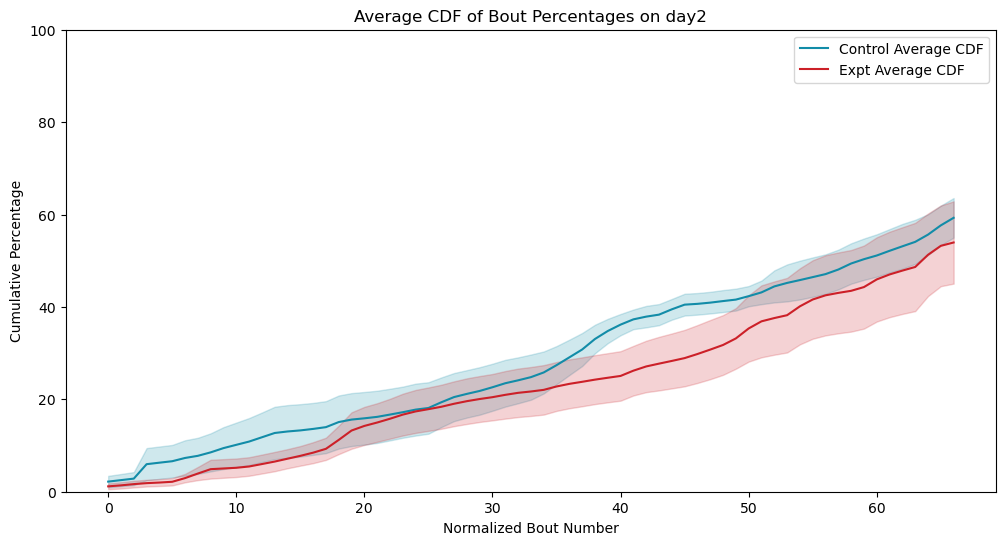

KS Test Statistic: 0.16417910447761194, P-value: 0.32905943681740746


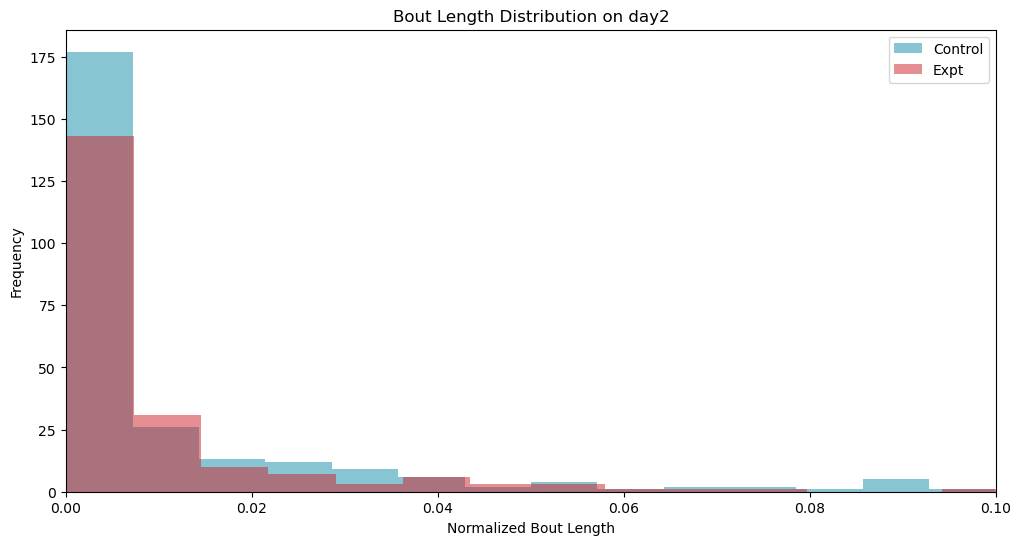

In [12]:
plot_bout_analysis(partner_bouts, figDataSaveDir + '/imagingInhib_behavior', filename='partner_bouts', preference_type='partner')

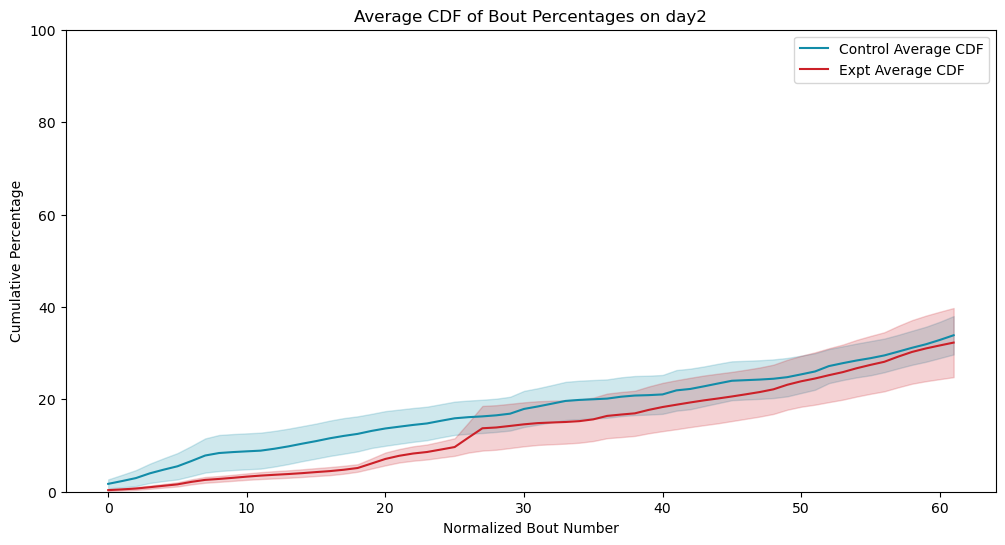

KS Test Statistic: 0.24193548387096775, P-value: 0.052751421711163045


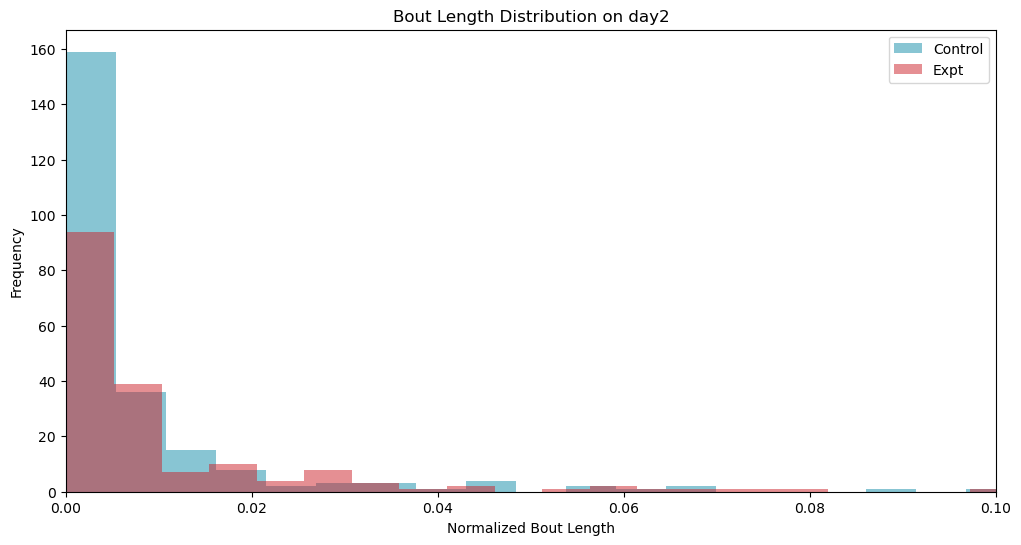

In [13]:
plot_bout_analysis(novel_bouts, figDataSaveDir + '/imagingInhib_behavior', filename='partner_bouts', preference_type='novel')

### day 0-1 % social cells

In [14]:
def analyze_and_plot(data_groups, event_type):
    results = {'control': {}, 'expt': {}}
    days = ['day0', 'day1']

    for group_name, group_data in data_groups.items():
        for animal_id, sessions in group_data.items():
            print(f"Processing {animal_id}")
            results[group_name][animal_id] = {}

            # Check if cellreg_0_2 exists and save it to the results
            if 'cellreg_0_2' in sessions:
                results[group_name][animal_id]['cellreg'] = sessions['cellreg_0_2']
                
            for day in days:
                #print(f"Processing {animal_id}, {day}")
                if day in sessions and 'cv' in sessions[day] and 'C_final' in sessions[day]:
                    cv = sessions[day]['cv']
                    C_final = sessions[day]['C_final']

                    # Check for NaN values and replace them
                    if np.isnan(C_final).any():
                        print(f"Replacing NaNs for {animal_id} on {day}")
                        C_final = np.nan_to_num(C_final)  # Replace NaNs with zero

                    total_frames = C_final.shape[1]

                    # Filter cv for specific EventType and generate labels
                    filtered_cv = cv[cv['EventType'] == event_type]
                    labels = generate_labels_from_cv_filtered(filtered_cv, total_frames)

                    # Calculate proportions of significant modulations
                    prop_positive, prop_negative, pos_indices, neg_indices, auroc_vals, p_vals = significant_modulation_proportion(C_final, labels)
                    prop_total = prop_positive + prop_negative  # Total proportion of significantly modulated neurons

                    results[group_name][animal_id][day] = {
                        'positive': prop_positive,
                        'negative': prop_negative,
                        'total': prop_total,
                        'pos_indices': pos_indices,
                        'neg_indices': neg_indices,
                        'auroc_vals': auroc_vals,
                        'p_vals': p_vals
                    }
                else:
                    print(f"Missing data for {animal_id} on {day}, skipping.")
                    
    return results


In [15]:
event_type = 'Distance between [ 2 and 1 ] Less Than  50.00 mm'  
day0_1_auROCs = analyze_and_plot({
    'control': data_groups_d01['control'],
    'expt': data_ssgroups_d01['expt']
}, event_type)

Processing animal1
Processing animal2
Processing animal3
Processing animal4
Processing animal5
Processing animal6
Processing animal7
Processing animal8
Processing animal9
Processing animal10
Replacing NaNs for animal10 on day0
Processing animal1
Processing animal2
Processing animal3
Processing animal4
Processing animal5
Processing animal6
Processing animal7
Replacing NaNs for animal7 on day1
Processing animal8


C:\Users\ephys\AppData\Local\Temp\ipykernel_27680\1769038691.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6))


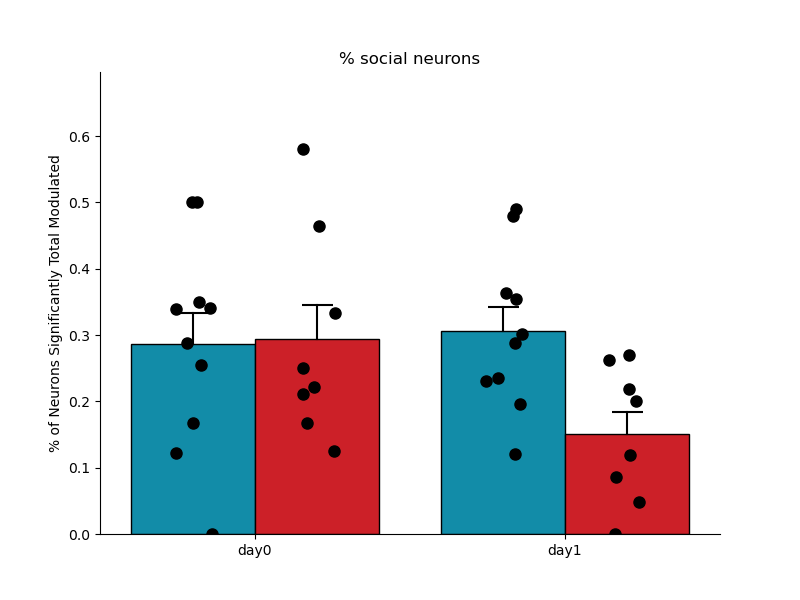

Figure data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\socialNeurons_day0_1_total_figure_data.csv
day0 - Independent t-test: t(16) = -0.10, p = 0.9180
Control: n=10, mean=0.29, SEM=0.05
Expt: n=8, mean=0.29, SEM=0.05

day1 - Independent t-test: t(16) = 2.99, p = 0.0086
Control: n=10, mean=0.31, SEM=0.04
Expt: n=8, mean=0.15, SEM=0.03


Mixed Effects Model Results:
----------------------------
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     proportion
No. Observations:     36          Method:                 REML      
No. Groups:           10          Scale:                  0.0186    
Min. group size:      2           Log-Likelihood:         13.9330   
Max. group size:      4           Converged:              Yes       
Mean group size:      3.6                                           
--------------------------------------------------------

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [56]:
def plot_modulation_results(results, save_dir, filename, modulation_type='total', whichDays=['day2', 'day14'], title_in='Default', ylabel=f'% of Neurons Significantly Modulated'):
    days = whichDays
    groups = ['control', 'expt']
    colors = {'control': '#128CA8', 'expt': '#CC2028'}
    
    # Data preparation for plotting and stats
    day_values = {day: {group: [] for group in groups} for day in days}
    data_for_mixedlm = []  # Collect data for mixed-effects linear model
    csv_data = {}  # Prepare data for CSV output

    # Collect data from results
    for group in groups:
        for day in days:
            for animal, animal_data in results[group].items():
                if day in animal_data:
                    proportion = animal_data[day][modulation_type]
                    day_values[day][group].append(proportion)
                    # Prepare data for mixed-effects model
                    data_for_mixedlm.append({
                        'group': group,
                        'day': day,
                        'proportion': proportion,
                        'animal': animal
                    })
                    
                    # Append data for CSV output
                    col_name = f"{group}_{day}"
                    if col_name not in csv_data:
                        csv_data[col_name] = []
                    csv_data[col_name].append(proportion)

    # Ensure all columns in csv_data have the same length
    max_length = max(len(values) for values in csv_data.values())
    for key in csv_data:
        csv_data[key].extend([np.nan] * (max_length - len(csv_data[key])))

    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    width = 0.4  # Width of the bars
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(top=False, right=False)
    
    # Plotting
    for i, day in enumerate(days):
        control_data = day_values[day]['control']
        expt_data = day_values[day]['expt']
        
        # Calculate means and SEMs
        mean_control = np.mean(control_data)
        mean_expt = np.mean(expt_data)
        se_control = np.std(control_data) / np.sqrt(len(control_data)) if len(control_data) > 1 else 0
        se_expt = np.std(expt_data) / np.sqrt(len(expt_data)) if len(expt_data) > 1 else 0
        
        # Calculate x positions
        control_x = i - 0.2
        expt_x = i + 0.2
        
        # Add jitter to x positions
        jitter_range = width/6  # Adjust this value to control amount of jitter
        control_xs = control_x + np.random.uniform(-jitter_range, jitter_range, len(control_data))
        expt_xs = expt_x + np.random.uniform(-jitter_range, jitter_range, len(expt_data))
        
        # Plot black dots with jitter
        ax.scatter(control_xs, control_data, color='black', s=64, zorder=3)
        ax.scatter(expt_xs, expt_data, color='black', s=64, zorder=3)
        
        # Plot bars with black outline
        ax.bar(control_x, mean_control, width=width, color=colors['control'], 
               edgecolor='black', zorder=2)
        ax.bar(expt_x, mean_expt, width=width, color=colors['expt'], 
               edgecolor='black', zorder=2)
        
        # Add SEM lines with horizontal ticks
        if se_control > 0:
            ax.plot([control_x, control_x], 
                   [mean_control, mean_control + se_control], 
                   color='black', linewidth=1.5, zorder=3)
            ax.hlines(mean_control + se_control, control_x-0.05, control_x+0.05, 
                     color='black', linewidth=1.5, zorder=3)
        
        if se_expt > 0:
            ax.plot([expt_x, expt_x], 
                   [mean_expt, mean_expt + se_expt], 
                   color='black', linewidth=1.5, zorder=3)
            ax.hlines(mean_expt + se_expt, expt_x-0.05, expt_x+0.05, 
                     color='black', linewidth=1.5, zorder=3)

    # Set labels and title
    ax.set_ylabel(ylabel)
    ax.set_title(title_in)
    
    # Set x-axis ticks and labels
    ax.set_xticks(range(len(days)))
    ax.set_xticklabels(days)
    
    # Set axis limits
    ax.set_xlim(-0.5, len(days) - 0.5)
    all_values = [val for day_dict in day_values.values() for group_list in day_dict.values() for val in group_list]
    ax.set_ylim(min(all_values) * 1.2, max(all_values) * 1.2)
    
    # Save plot
    save_path_svg = os.path.join(save_dir, filename + '.svg')
    save_path_png = os.path.join(save_dir, filename + '.png')
    plt.savefig(save_path_svg, format='svg', bbox_inches='tight')
    plt.savefig(save_path_png, format='png', bbox_inches='tight')    
    plt.show()

    # Save data to CSV
    csv_file_path = os.path.join(save_dir, filename + '_figure_data.csv')
    csv_df = pd.DataFrame(csv_data)
    csv_df.to_csv(csv_file_path, index=False)
    print(f"Figure data saved to {csv_file_path}")

    # Statistical tests and mixed-effects linear model
    for day in days:
        control_data = day_values[day]['control']
        expt_data = day_values[day]['expt']
        
        # Independent t-test
        t_stat, p_value = stats.ttest_ind(control_data, expt_data, equal_var=False)  # Welch's t-test
        df_value = len(control_data) + len(expt_data) - 2  # Degrees of freedom
        print(f'{day} - Independent t-test: t({df_value}) = {t_stat:.2f}, p = {p_value:.4f}')
        # Print detailed statistics
        print(f"Control: n={len(control_data)}, mean={np.mean(control_data):.2f}, SEM={np.std(control_data)/np.sqrt(len(control_data)):.2f}")
        print(f"Expt: n={len(expt_data)}, mean={np.mean(expt_data):.2f}, SEM={np.std(expt_data)/np.sqrt(len(expt_data)):.2f}\n")
    
    # Mixed-effects model analysis
    df_mixedlm = pd.DataFrame(data_for_mixedlm)
    model = smf.mixedlm('proportion ~ group * day', df_mixedlm, groups=df_mixedlm['animal'])
    mixedlm_result = model.fit()
    
    # Print the mixed-effects model results
    print("\nMixed Effects Model Results:")
    print("----------------------------")
    print(mixedlm_result.summary())
    
    # Save the mixed-effects model results to a text file
    with open(os.path.join(save_dir, filename + '_mixedlm_results.txt'), 'w') as f:
        f.write(mixedlm_result.summary().as_text())
        
modulation_type = 'total'
plot_modulation_results(day0_1_auROCs, save_dir=figDataSaveDir + '/imagingInhib_cells', filename=f"socialNeurons_day0_1_{modulation_type}", ylabel=f'% of Neurons Significantly {modulation_type.capitalize()} Modulated', modulation_type=modulation_type, whichDays = ['day0', 'day1'], title_in = "% social neurons")


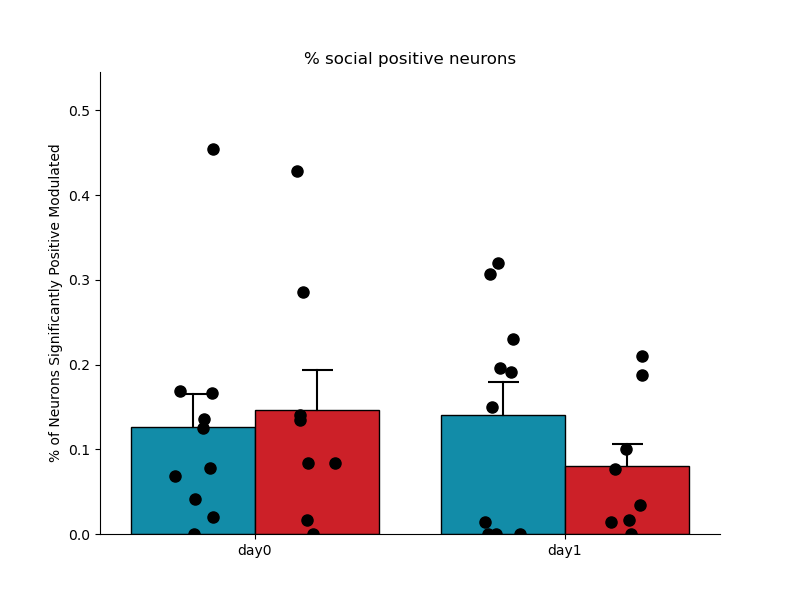

Figure data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\socialNeurons_day0_1_positive_figure_data.csv
day0 - Independent t-test: t(16) = -0.31, p = 0.7586
Control: n=10, mean=0.13, SEM=0.04
Expt: n=8, mean=0.15, SEM=0.05

day1 - Independent t-test: t(16) = 1.23, p = 0.2380
Control: n=10, mean=0.14, SEM=0.04
Expt: n=8, mean=0.08, SEM=0.03


Mixed Effects Model Results:
----------------------------
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     proportion
No. Observations:     36          Method:                 REML      
No. Groups:           10          Scale:                  0.0143    
Min. group size:      2           Log-Likelihood:         17.1249   
Max. group size:      4           Converged:              Yes       
Mean group size:      3.6                                           
-----------------------------------------------------

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [57]:
modulation_type = 'positive'
plot_modulation_results(day0_1_auROCs, save_dir=figDataSaveDir + '/imagingInhib_cells', filename=f"socialNeurons_day0_1_{modulation_type}", ylabel=f'% of Neurons Significantly {modulation_type.capitalize()} Modulated', modulation_type=modulation_type, whichDays = ['day0', 'day1'], title_in = "% social positive neurons")


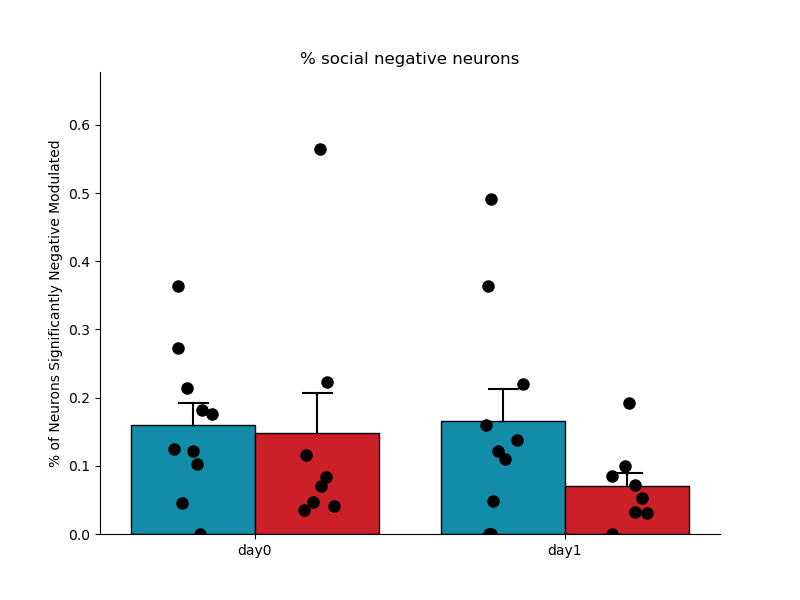

Figure data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\socialNeurons_day0_1_negative_figure_data.csv
day0 - Independent t-test: t(16) = 0.18, p = 0.8629
Control: n=10, mean=0.16, SEM=0.03
Expt: n=8, mean=0.15, SEM=0.06

day1 - Independent t-test: t(16) = 1.76, p = 0.1048
Control: n=10, mean=0.17, SEM=0.05
Expt: n=8, mean=0.07, SEM=0.02


Mixed Effects Model Results:
----------------------------
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     proportion
No. Observations:     36          Method:                 REML      
No. Groups:           10          Scale:                  0.0171    
Min. group size:      2           Log-Likelihood:         14.5978   
Max. group size:      4           Converged:              Yes       
Mean group size:      3.6                                           
------------------------------------------------------

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [58]:
modulation_type = 'negative'
plot_modulation_results(day0_1_auROCs, save_dir=figDataSaveDir + '/imagingInhib_cells', filename=f"socialNeurons_day0_1_{modulation_type}", ylabel=f'% of Neurons Significantly {modulation_type.capitalize()} Modulated', modulation_type=modulation_type, whichDays = ['day0', 'day1'], title_in = "% social negative neurons")


### PPT auROC code

In [19]:
def analyze_and_plot_PPTs(data_groups, days=['day2', 'day14'], context='partner', eventType = 'ppref'):
    results = {'control': {}, 'expt': {}}

    for group_name, group_data in data_groups.items():
        for animal_id, sessions in group_data.items():
            print(animal_id)
            results[group_name][animal_id] = {}

            # Check if cellreg_0_2 exists and save it to the results
            if 'cellreg_0_2' in sessions:
                results[group_name][animal_id]['cellreg'] = sessions['cellreg_0_2']
                
            for day in days:
                session_data = sessions.get(day)
                if session_data and 'cv' in session_data and 'C_final' in session_data:
                    cv = session_data['cv']
                    C_final = session_data['C_final']

                    # Replace NaNs in C_final with zeros
                    if np.isnan(C_final).any():
                        print(f"Replacing NaNs for {animal_id} on {day}")
                        C_final = np.nan_to_num(C_final)

                    # Determine the side based on partner_side_by_day info and context
                    side_info = session_data.get('partner_side', '').capitalize()
                    if eventType == 'ppref':
                        if side_info:
                            # Define event types based on the side and context
                            if context == 'partner':
                                event_type = f'Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030'
                            elif context == 'novel':
                                opposite_side = 'Right' if side_info == 'Left' else 'Left'
                                event_type = f'Social Contact [ 1 with 3 ] in Area Right while Joint Motion < 0.030'
                            elif context == 'social':
                                event_type = [
                                    'Social Contact [ 1 with 2 ] in Area Left while Joint Motion < 0.030',
                                    'Social Contact [ 1 with 3 ] in Area Right while Joint Motion < 0.030'
                                ]
                    else:
                        if side_info:
                            # Define event types based on the side and context
                            if context == 'partner':
                                event_type = f'Area:Mouse 1 Center In {side_info} chamber'
                            elif context == 'novel':
                                opposite_side = 'Right' if side_info == 'Left' else 'Left'
                                event_type = f'Area:Mouse 1 Center In {opposite_side} chamber'
                            elif context == 'nonsocial':
                                event_type = [
                                    f'Area:Mouse 1 Center In Center chamber'
                                ]

                    # Filter CV for specified EventType
                    if isinstance(event_type, list):
                        filtered_cv = cv[cv['EventType'].isin(event_type)]
                    else:
                        filtered_cv = cv[cv['EventType'] == event_type]
                        
                    labels = generate_labels_from_cv_filtered(filtered_cv, C_final.shape[1])

                    # Calculate auROC and determine significant modulation
                    prop_positive, prop_negative, pos_indices, neg_indices, auroc_vals, p_vals = significant_modulation_proportion(C_final, labels, significance_level=0.025)
                    prop_total = prop_positive + prop_negative  # Total proportion of significantly modulated neurons

                    results[group_name][animal_id][day] = {
                        'positive': prop_positive,
                        'negative': prop_negative,
                        'total': prop_total,
                        'pos_indices': pos_indices,
                        'neg_indices': neg_indices,
                        'auroc_vals': auroc_vals,
                        'p_vals': p_vals
                    }
                else:
                    print(f"Missing data for {animal_id} on {day}, skipping.")
                    
    return results


### day 2/14 % partner cells

In [20]:
day2_14_auROCs_partner = analyze_and_plot_PPTs(data_groups_d2, context='partner', eventType = 'chamber')


animal1
animal2
animal3
animal4
animal5
animal6
Replacing NaNs for animal6 on day14
animal7
animal8
animal1
animal2
animal3
animal4
animal5
animal6
animal7


### day 2/15 % stranger cells

In [21]:
day2_14_auROCs_novel = analyze_and_plot_PPTs(data_groups_d2, context='novel', eventType = 'chamber')


animal1
animal2
animal3
animal4
animal5
animal6
Replacing NaNs for animal6 on day14
animal7
animal8
animal1
animal2
animal3
animal4
animal5
animal6
animal7


In [68]:
# Optional but just to allow for reloading if notebook crashes etc
# Create a dictionary to hold all variables
data_to_pickle = {
    'day0_1_auROCs': day0_1_auROCs,
    'day2_14_auROCs_partner': day2_14_auROCs_partner,
    'day2_14_auROCs_novel': day2_14_auROCs_novel
}

savedCellEncodingFilename = figDataSaveDir + '/cellEncoding_012325.pkl'

# Write the data to a pickle file
with open(savedCellEncodingFilename, 'wb') as f:
    pickle.dump(data_to_pickle, f)

print(f"Data has been successfully written to {savedCellEncodingFilename}")

Data has been successfully written to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/cellEncoding_012325.pkl


In [59]:
def plot_modulation_results_two_results(
    results1, 
    results2, 
    save_dir, 
    filename, 
    modulation_type='total', 
    day='day2', 
    title_in='Default', 
    ylabel='% of Neurons Significantly Modulated'
):
    groups = ['control', 'expt']
    colors = {
        'control_partner': '#128CA8',    # dark blue
        'control_novel': '#D2DEE6',      # light blue
        'expt_partner': '#CC2028',       # dark red
        'expt_novel': '#F6DAD0'          # light red
    }
    
    # Data preparation for plotting and stats
    day_values1 = {group: [] for group in groups}  # Partner
    day_values2 = {group: [] for group in groups}  # Novel
    paired_data = {group: [] for group in groups}  # For connecting lines
    data_for_mixedlm = []
    
    # Create lists to store paired data for CSV
    animal_ids = []
    partner_values = []
    novel_values = []
    group_labels = []
    
    # Collect paired data
    for group in groups:
        # Get all animal IDs that have data in both results
        animals = set(results1[group].keys()) & set(results2[group].keys())
        
        for animal in animals:
            if day in results1[group][animal] and day in results2[group][animal]:
                partner_val = results1[group][animal][day][modulation_type]
                novel_val = results2[group][animal][day][modulation_type]
                
                # Store data for plotting
                day_values1[group].append(partner_val)
                day_values2[group].append(novel_val)
                paired_data[group].append((partner_val, novel_val))
                
                # Store data for CSV
                animal_ids.append(animal)
                partner_values.append(partner_val)
                novel_values.append(novel_val)
                group_labels.append(group)
                
                # Store for mixed effects model - using proper coding for factors
                data_for_mixedlm.extend([
                    {'group': 1 if group == 'expt' else 0,
                     'condition': 1,    # Effect coding: stranger=0, partner=1
                     'proportion': partner_val, 
                     'animal': animal},
                    {'group': 1 if group == 'expt' else 0,
                     'condition': 0,
                     'proportion': novel_val, 
                     'animal': animal}
                ])
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(top=False, right=False)
    
    width = 0.4
    positions = {
        'control_partner': 0,
        'expt_partner': 0.5,
        'control_novel': 2,
        'expt_novel': 2.5
    }
    
    # Plot bars and individual data points
    for group in groups:
        # Partner data
        mean_partner = np.mean(day_values1[group])
        sem_partner = np.std(day_values1[group]) / np.sqrt(len(day_values1[group]))
        pos_partner = positions[f'{group}_partner']
        
        # Add jitter to partner data points
        jitter_range = width/6
        partner_xs = pos_partner + np.random.uniform(-jitter_range, jitter_range, len(day_values1[group]))
        
        # Plot partner bar
        ax.bar(pos_partner, mean_partner, width, color=colors[f'{group}_partner'], 
               edgecolor='black', zorder=2)
        
        # Plot individual partner data points
        ax.scatter(partner_xs, day_values1[group], color='black', s=64, zorder=3)
        
        # Add partner SEM lines
        ax.plot([pos_partner, pos_partner], 
                [mean_partner, mean_partner + sem_partner], 
                color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_partner + sem_partner, pos_partner-0.05, pos_partner+0.05, 
                 color='black', linewidth=1.5, zorder=3)
        
        # Novel data
        mean_novel = np.mean(day_values2[group])
        sem_novel = np.std(day_values2[group]) / np.sqrt(len(day_values2[group]))
        pos_novel = positions[f'{group}_novel']
        
        # Add jitter to novel data points
        novel_xs = pos_novel + np.random.uniform(-jitter_range, jitter_range, len(day_values2[group]))
        
        # Plot novel bar
        ax.bar(pos_novel, mean_novel, width, color=colors[f'{group}_novel'], 
               edgecolor='black', zorder=2)
        
        # Plot individual novel data points
        ax.scatter(novel_xs, day_values2[group], color='black', s=64, zorder=3)
        
        # Add novel SEM lines
        ax.plot([pos_novel, pos_novel], 
                [mean_novel, mean_novel + sem_novel], 
                color='black', linewidth=1.5, zorder=3)
        ax.hlines(mean_novel + sem_novel, pos_novel-0.05, pos_novel+0.05, 
                 color='black', linewidth=1.5, zorder=3)
        
        # Removed connecting lines
    
    # Set labels and title
    ax.set_ylabel(ylabel)
    ax.set_title(title_in)
    
    # Set x-axis ticks and labels
    ax.set_xticks([0.25, 2.25])
    ax.set_xticklabels(['Partner', 'Novel'])
    
    # Add a legend
    legend_elements = [
        Patch(facecolor=colors['control_partner'], edgecolor='black', label='Vehicle'),
        Patch(facecolor=colors['expt_partner'], edgecolor='black', label='IEM-1460')
    ]
    ax.legend(handles=legend_elements, loc='upper right', frameon=False)
    
    # Set y-axis limits (ensure it starts at 0)
    all_values = [val for group in day_values1.values() for val in group] + \
                [val for group in day_values2.values() for val in group]
    ax.set_ylim(0, max(all_values) * 1.2)
    
    # Save plot
    plt.savefig(os.path.join(save_dir, filename + '.svg'), format='svg', bbox_inches='tight')
    plt.savefig(os.path.join(save_dir, filename + '.png'), format='png', bbox_inches='tight')
    plt.show()

    # Save data to CSV
    csv_data = {
        'animal_id': animal_ids,
        'group': group_labels,
        'partner_value': partner_values,
        'novel_value': novel_values
    }
    csv_df = pd.DataFrame(csv_data)
    csv_df.to_csv(os.path.join(save_dir, filename + '_figure_data.csv'), index=False)

    # Statistical tests - between-group comparisons for each condition
    # Partner condition: control vs expt
    t_stat, p_value = stats.ttest_ind(day_values1['control'], day_values1['expt'], equal_var=False)
    n_ctrl = len(day_values1['control'])
    n_expt = len(day_values1['expt'])
    print("\nPartner Condition - Control vs IEM-1460:")
    print(f"Control: n={n_ctrl}, mean={np.mean(day_values1['control']):.2f}, "
          f"SEM={np.std(day_values1['control'])/np.sqrt(n_ctrl):.2f}")
    print(f"IEM-1460: n={n_expt}, mean={np.mean(day_values1['expt']):.2f}, "
          f"SEM={np.std(day_values1['expt'])/np.sqrt(n_expt):.2f}")
    print(f"Independent t-test: t({n_ctrl + n_expt - 2}) = {t_stat:.2f}, p = {p_value:.3f}")

    # Novel condition: control vs expt
    t_stat, p_value = stats.ttest_ind(day_values2['control'], day_values2['expt'], equal_var=False)
    print("\nNovel Condition - Control vs IEM-1460:")
    print(f"Control: n={n_ctrl}, mean={np.mean(day_values2['control']):.2f}, "
          f"SEM={np.std(day_values2['control'])/np.sqrt(n_ctrl):.2f}")
    print(f"IEM-1460: n={n_expt}, mean={np.mean(day_values2['expt']):.2f}, "
          f"SEM={np.std(day_values2['expt'])/np.sqrt(n_expt):.2f}")
    print(f"Independent t-test: t({n_ctrl + n_expt - 2}) = {t_stat:.2f}, p = {p_value:.3f}")

    # Mixed-effects model with proper contrast coding
    df_mixedlm = pd.DataFrame(data_for_mixedlm)
    
    # Fit the mixed effects model
    model = smf.mixedlm('proportion ~ group * condition', 
                       data=df_mixedlm, 
                       groups='animal',
                       re_formula='~condition')  # Random slope for within-subject factor
    
    mixedlm_result = model.fit()
    
    # Extract and format key results
    coef_table = pd.DataFrame({
        'Coefficient': mixedlm_result.params,
        'Std Error': mixedlm_result.bse,
        't-value': mixedlm_result.tvalues,
        'P-value': mixedlm_result.pvalues
    })
    
    # Save detailed statistical results
    with open(os.path.join(save_dir, filename + '_statistical_results.txt'), 'w') as f:
        # Write formatted results
        f.write("Linear Mixed Model Results\n")
        f.write("==========================\n\n")
        
        f.write("Model Information:\n")
        f.write(f"Number of observations: {len(df_mixedlm)}\n")
        f.write(f"Number of groups (animals): {len(df_mixedlm['animal'].unique())}\n\n")
        
        f.write("Fixed Effects:\n")
        f.write("-------------\n")
        f.write("Intercept: Overall mean\n")
        f.write("group: Effect of IEM-1460 (0=Vehicle, 1=IEM-1460)\n")
        f.write("condition: Effect of partner vs stranger (0=stranger, 1=partner)\n")
        f.write("group:condition: Interaction between treatment and social condition\n\n")
        
        coef_table_formatted = coef_table.copy()
        coef_table_formatted['P-value'] = coef_table_formatted['P-value'].apply(
            lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.4f}")
        
        for col in ['Coefficient', 'Std Error', 't-value']:
            coef_table_formatted[col] = coef_table_formatted[col].round(4)
            
        f.write(coef_table_formatted.to_string())
        f.write("\n\n")
        
        f.write("\nFull Model Summary:\n")
        f.write("------------------\n")
        f.write(mixedlm_result.summary().as_text())
        
    # Print key results to console
    print("\nLinear Mixed Model Results:")
    print("---------------------------")
    print("\nFixed Effects:")
    coef_table_formatted = coef_table.copy()
    coef_table_formatted['P-value'] = coef_table_formatted['P-value'].apply(
        lambda x: f"{x:.2e}" if x < 0.001 else f"{x:.4f}")
    
    for col in ['Coefficient', 'Std Error', 't-value']:
        coef_table_formatted[col] = coef_table_formatted[col].round(4)
        
    print(coef_table_formatted)
    
    # Print detailed interpretation of the linear mixed model results
    print("\nDetailed Linear Mixed Model Results:")
    print("------------------------------------")
    print("Fixed Effects Interpretation:")
    
    # Extract coefficients and p-values
    intercept = mixedlm_result.params['Intercept']
    group_effect = mixedlm_result.params['group']
    condition_effect = mixedlm_result.params['condition']
    interaction = mixedlm_result.params['group:condition']
    
    # Get p-values
    p_group = mixedlm_result.pvalues['group']
    p_condition = mixedlm_result.pvalues['condition']
    p_interaction = mixedlm_result.pvalues['group:condition']
    
    print(f"\nMain effect of treatment (IEM-1460 vs Vehicle):")
    print(f"Coefficient = {group_effect:.3f}, p = {p_group:.4f}")
    
    print(f"\nMain effect of condition (Partner vs Novel):")
    print(f"Coefficient = {condition_effect:.3f}, p = {p_condition:.4f}")
    
    print(f"\nInteraction between treatment and condition:")
    print(f"Coefficient = {interaction:.3f}, p = {p_interaction:.4f}")
    
    # Print model fit statistics
    print("\nModel Fit:")
    print(f"AIC: {mixedlm_result.aic:.2f}")
    print(f"BIC: {mixedlm_result.bic:.2f}")
    print(f"Log-likelihood: {mixedlm_result.llf:.2f}")
    
    return mixedlm_result

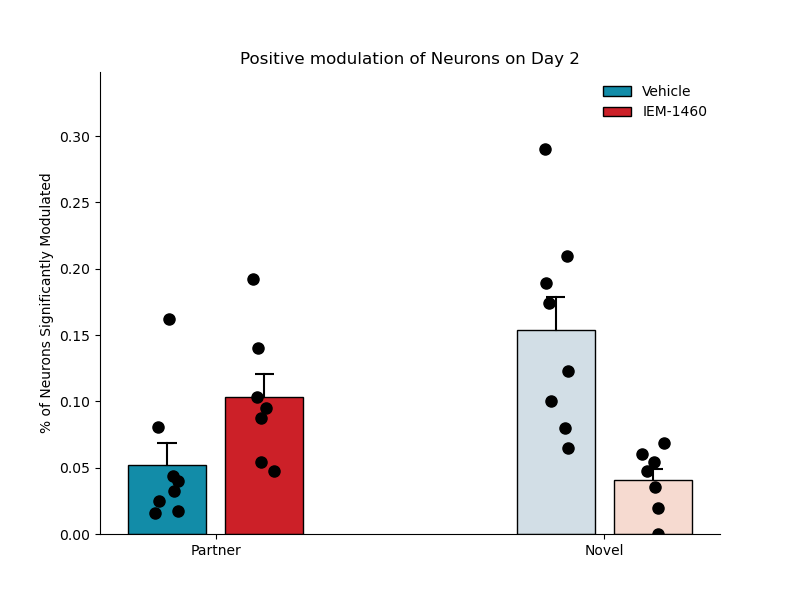


Partner Condition - Control vs IEM-1460:
Control: n=8, mean=0.05, SEM=0.02
IEM-1460: n=7, mean=0.10, SEM=0.02
Independent t-test: t(13) = -1.98, p = 0.070

Novel Condition - Control vs IEM-1460:
Control: n=8, mean=0.15, SEM=0.03
IEM-1460: n=7, mean=0.04, SEM=0.01
Independent t-test: t(13) = 3.97, p = 0.004


C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(



Linear Mixed Model Results:
---------------------------

Fixed Effects:
                        Coefficient  Std Error  t-value   P-value
Intercept                    0.1538     0.0185   8.2913  1.12e-16
group                       -0.1131     0.0274  -4.1258  3.70e-05
condition                   -0.1017     0.0277  -3.6679  2.45e-04
group:condition              0.1638     0.0387   4.2264  2.37e-05
animal Var                   0.0068     0.4287   0.0158    0.9874
animal x condition Cov      -0.0256     0.6446  -0.0397    0.9683
condition Var                0.2473     1.6548   0.1494    0.8812

Detailed Linear Mixed Model Results:
------------------------------------
Fixed Effects Interpretation:

Main effect of treatment (IEM-1460 vs Vehicle):
Coefficient = -0.113, p = 0.0000

Main effect of condition (Partner vs Novel):
Coefficient = -0.102, p = 0.0002

Interaction between treatment and condition:
Coefficient = 0.164, p = 0.0000

Model Fit:
AIC: nan
BIC: nan
Log-likelihood: 34.65


C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.515878
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [60]:
plot_modulation_results_two_results(day2_14_auROCs_partner, day2_14_auROCs_novel, 
                                    save_dir=figDataSaveDir + '/imagingInhib_cells', 
                                    filename=f"day2_positive_modulation", title_in='Positive modulation of Neurons on Day 2', 
                                    modulation_type='positive')


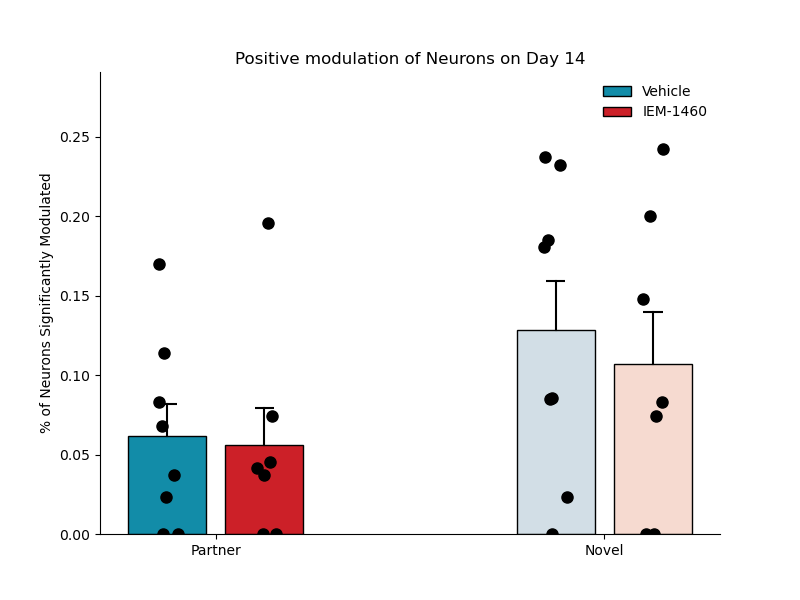


Partner Condition - Control vs IEM-1460:
Control: n=8, mean=0.06, SEM=0.02
IEM-1460: n=7, mean=0.06, SEM=0.02
Independent t-test: t(13) = 0.17, p = 0.865

Novel Condition - Control vs IEM-1460:
Control: n=8, mean=0.13, SEM=0.03
IEM-1460: n=7, mean=0.11, SEM=0.03
Independent t-test: t(13) = 0.45, p = 0.659

Linear Mixed Model Results:
---------------------------

Fixed Effects:
                        Coefficient  Std Error  t-value   P-value
Intercept                    0.1287     0.0287   4.4822  7.39e-06
group                       -0.0207     0.0410  -0.5052    0.6134
condition                   -0.0667     0.0401  -1.6621    0.0965
group:condition              0.0148     0.0578   0.2557    0.7982
animal Var                   0.0815     0.4509   0.1807    0.8566
animal x condition Cov      -0.0959     0.5885  -0.1629    0.8706
condition Var                0.1133     0.9117   0.1243    0.9011

Detailed Linear Mixed Model Results:
------------------------------------
Fixed Effects In

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [61]:
plot_modulation_results_two_results(day2_14_auROCs_partner, day2_14_auROCs_novel, 
                                    save_dir=figDataSaveDir + '/imagingInhib_cells', 
                                    filename=f"day14_positive_modulation", day='day14', 
                                    title_in='Positive modulation of Neurons on Day 14', 
                                    modulation_type='positive')


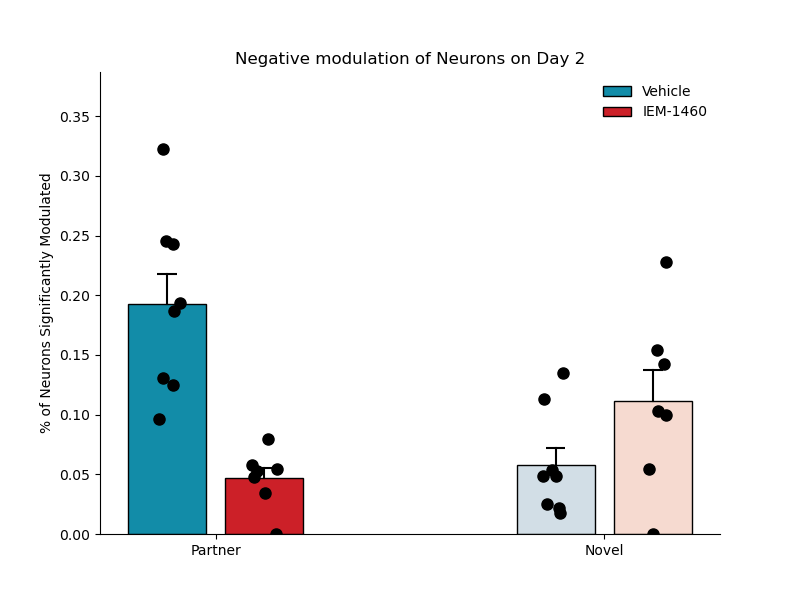


Partner Condition - Control vs IEM-1460:
Control: n=8, mean=0.19, SEM=0.02
IEM-1460: n=7, mean=0.05, SEM=0.01
Independent t-test: t(13) = 5.17, p = 0.001

Novel Condition - Control vs IEM-1460:
Control: n=8, mean=0.06, SEM=0.01
IEM-1460: n=7, mean=0.11, SEM=0.03
Independent t-test: t(13) = -1.71, p = 0.121

Linear Mixed Model Results:
---------------------------

Fixed Effects:
                        Coefficient  Std Error  t-value   P-value
Intercept                    0.0578     0.0207   2.7954    0.0052
group                        0.0540     0.0302   1.7881    0.0738
condition                    0.1352     0.0293   4.6143  3.94e-06
group:condition             -0.2003     0.0428  -4.6827  2.83e-06
animal Var                   0.0018        NaN      NaN       nan
animal x condition Cov      -0.0038        NaN      NaN       nan
condition Var                0.0109        NaN      NaN       nan

Detailed Linear Mixed Model Results:
------------------------------------
Fixed Effects I

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [62]:
plot_modulation_results_two_results(day2_14_auROCs_partner, day2_14_auROCs_novel, 
                                    save_dir=figDataSaveDir + '/imagingInhib_cells_supp', 
                                    filename=f"day2_negative_modulation", title_in='Negative modulation of Neurons on Day 2', 
                                    modulation_type='negative')


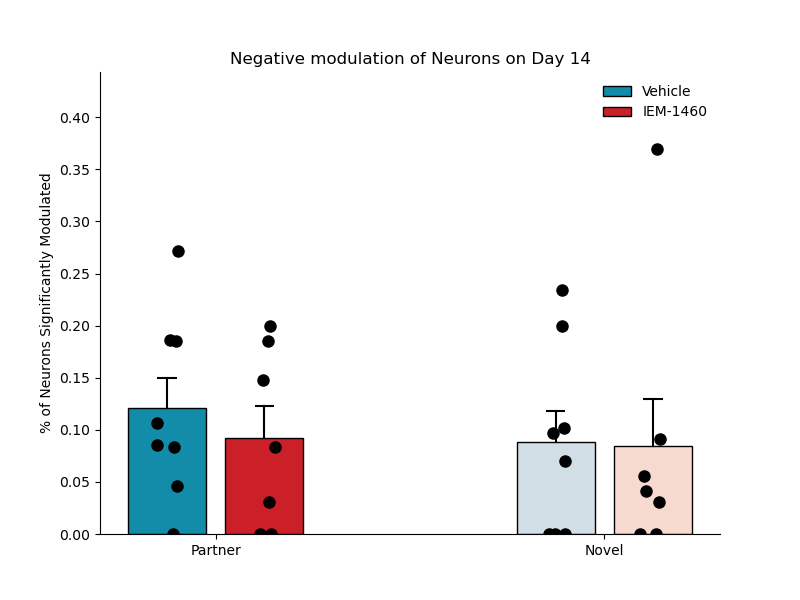


Partner Condition - Control vs IEM-1460:
Control: n=8, mean=0.12, SEM=0.03
IEM-1460: n=7, mean=0.09, SEM=0.03
Independent t-test: t(13) = 0.63, p = 0.542

Novel Condition - Control vs IEM-1460:
Control: n=8, mean=0.09, SEM=0.03
IEM-1460: n=7, mean=0.08, SEM=0.05
Independent t-test: t(13) = 0.07, p = 0.949

Linear Mixed Model Results:
---------------------------

Fixed Effects:
                        Coefficient  Std Error  t-value P-value
Intercept                    0.0878     0.0358   2.4531  0.0142
group                       -0.0046     0.0500  -0.0916  0.9270
condition                    0.0327     0.0507   0.6448  0.5190
group:condition             -0.0232     0.0709  -0.3266  0.7440
animal Var                   0.1173     0.3895   0.3012  0.7633
animal x condition Cov      -0.1672     0.4454  -0.3754  0.7074
condition Var                0.2416     0.7828   0.3086  0.7576

Detailed Linear Mixed Model Results:
------------------------------------
Fixed Effects Interpretation:

M

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

In [63]:
plot_modulation_results_two_results(day2_14_auROCs_partner, day2_14_auROCs_novel, 
                                    save_dir=figDataSaveDir + '/imagingInhib_cells_supp', 
                                    filename=f"day14_negative_modulation", day='day14', 
                                    title_in='Negative modulation of Neurons on Day 14', 
                                    modulation_type='negative')


### difference scores

Test for day2 (total): t-statistic = -6.81, p-value = 0.0000
Test for day14 (total): t-statistic = -0.28, p-value = 0.7875
Test for day2 (positive): t-statistic = -5.24, p-value = 0.0002
Test for day14 (positive): t-statistic = -0.24, p-value = 0.8138
Test for day2 (negative): t-statistic = 6.26, p-value = 0.0000
Test for day14 (negative): t-statistic = 0.28, p-value = 0.7845


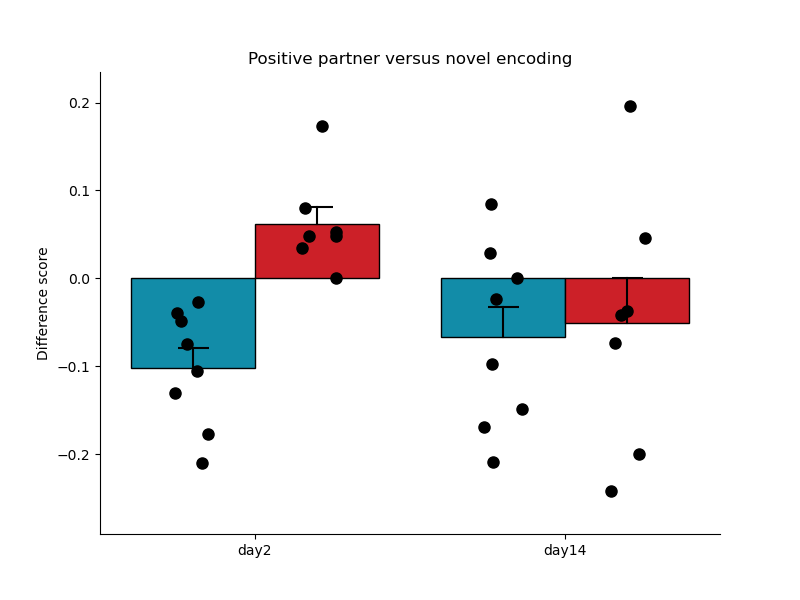

Figure data saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\difference_scores_positive_plot_figure_data.csv
day2 - Independent t-test: t(13) = -5.24, p = 0.0002
Control: n=8, mean=-0.10, SEM=0.02
Expt: n=7, mean=0.06, SEM=0.02

day14 - Independent t-test: t(13) = -0.24, p = 0.8138
Control: n=8, mean=-0.07, SEM=0.03
Expt: n=7, mean=-0.05, SEM=0.05


Mixed Effects Model Results:
----------------------------
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     proportion
No. Observations:     30          Method:                 REML      
No. Groups:           8           Scale:                  0.0095    
Min. group size:      2           Log-Likelihood:         19.0075   
Max. group size:      4           Converged:              No        
Mean group size:      3.8                                           
------------------------------------------------

C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge

In [64]:
def calculate_difference_scores(day2_14_auROCs, day2_14_auROCs_novel, directory):
    groups = ['control', 'expt']
    days = ['day2', 'day14']  # Include both Day 2 and Day 14
    difference_scores = {group: {} for group in groups}
    difference_scores_positive = {group: {} for group in groups}
    difference_scores_negative = {group: {} for group in groups}

    # Prepare a list to store data for the CSV
    csv_data = []

    for group in groups:
        for animal in day2_14_auROCs[group]:
            difference_scores[group][animal] = {}
            difference_scores_positive[group][animal] = {}
            difference_scores_negative[group][animal] = {}
            for day in days:
                if day in day2_14_auROCs[group][animal] and day in day2_14_auROCs_novel[group][animal]:
                    pos_partner = day2_14_auROCs[group][animal][day]['positive']
                    pos_novel = day2_14_auROCs_novel[group][animal][day]['positive']
                    neg_partner = day2_14_auROCs[group][animal][day]['negative']
                    neg_novel = day2_14_auROCs_novel[group][animal][day]['negative']
                    
                    difference_score_total = (pos_partner - pos_novel) - (neg_partner - neg_novel)
                    difference_score_positive = pos_partner - pos_novel
                    difference_score_negative = neg_partner - neg_novel
                    
                    difference_scores[group][animal][day] = {'total': difference_score_total}
                    difference_scores_positive[group][animal][day] = {'positive': difference_score_positive}
                    difference_scores_negative[group][animal][day] = {'negative': difference_score_negative}

                    # Append Day 2 and Day 14 data for CSV
                    csv_data.append({
                        'Group': group,
                        'Animal': animal,
                        'Day': day,
                        'Positive_Partner': pos_partner,
                        'Positive_Novel': pos_novel,
                        'Negative_Partner': neg_partner,
                        'Negative_Novel': neg_novel,
                        'Difference_Total': difference_score_total,
                        'Difference_Positive': difference_score_positive,
                        'Difference_Negative': difference_score_negative
                    })

    # Convert to DataFrame and save as CSV
    df = pd.DataFrame(csv_data)
    csv_path = os.path.join(directory, 'positive_partner_novel_day2_14_values.csv')
    df.to_csv(csv_path, index=False)

    return difference_scores, difference_scores_positive, difference_scores_negative

def run_t_tests(difference_scores, score_type='total'):
    groups = ['control', 'expt']
    days = ['day2', 'day14']  # Include both days for t-tests
    
    for day in days:
        control_scores = [difference_scores['control'][animal][day][score_type] for animal in difference_scores['control'] if day in difference_scores['control'][animal]]
        expt_scores = [difference_scores['expt'][animal][day][score_type] for animal in difference_scores['expt'] if day in difference_scores['expt'][animal]]
        t_stat, p_val = ttest_ind(control_scores, expt_scores, equal_var=False)
        print(f'Test for {day} ({score_type}): t-statistic = {t_stat:.2f}, p-value = {p_val:.4f}')


def save_difference_scores(difference_scores, filename):
    np.save(filename, difference_scores)


# Calculate the difference scores for both days
difference_scores_total, difference_scores_positive, difference_scores_negative = calculate_difference_scores(day2_14_auROCs_partner, day2_14_auROCs_novel, 
                                                                                                              directory=figDataSaveDir + '/imagingInhib_cells')

# Run t-tests for each type of difference score
run_t_tests(difference_scores_total, 'total')
run_t_tests(difference_scores_positive, 'positive')
run_t_tests(difference_scores_negative, 'negative')

# Save the difference scores
save_difference_scores(difference_scores_total, 'difference_scores_total.npy')
save_difference_scores(difference_scores_positive, 'difference_scores_positive.npy')
save_difference_scores(difference_scores_negative, 'difference_scores_negative.npy')

# Load the saved data and use it with plot_modulation_results
loaded_difference_scores_total = np.load('difference_scores_total.npy', allow_pickle=True).item()
loaded_difference_scores_positive = np.load('difference_scores_positive.npy', allow_pickle=True).item()
loaded_difference_scores_negative = np.load('difference_scores_negative.npy', allow_pickle=True).item()


plot_modulation_results(loaded_difference_scores_positive, save_dir=figDataSaveDir + '/imagingInhib_cells', filename='difference_scores_positive_plot', modulation_type='positive', title_in='Positive partner versus novel encoding', ylabel='Difference score')



### specific neuron viz

In [28]:
def visualize_neuron_data(neuron_data, title_in=None):
    """
    Load neuron data from a pickle file and reproduce the visualizations.

    Parameters:
        pickle_path (str): The path to the pickle file.

    Returns:
        None
    """

    num_neurons = len(neuron_data)
    fig, axes = plt.subplots(num_neurons, 1, figsize=(12, 6 * num_neurons), sharex=True)
    if num_neurons == 1:  # Handle single neuron case
        axes = [axes]

    for i, neuron in enumerate(neuron_data):
        neuron_trace = neuron['Fluorescence']
        gray_bar = neuron['GrayBar']
        start_time = neuron['start_time']
        end_time = neuron['end_time']
        color = neuron.get('color', '#000000')
        
        # Plot timeseries
        axes[i].plot(neuron_trace, color=color)

        # Highlight gray bar regions
        for idx, is_gray in enumerate(gray_bar):
            if is_gray == 1:
                axes[i].axvspan(idx, idx + 1, color='gray', alpha=0.3)
        
        axes[i].set_ylabel('Fluorescence')
        axes[i].label_outer()  # Hide x labels and ticks except for bottom plot
    
    fig.suptitle(title_in if title_in else 'Neuron Traces')
    plt.tight_layout()
    plt.show()



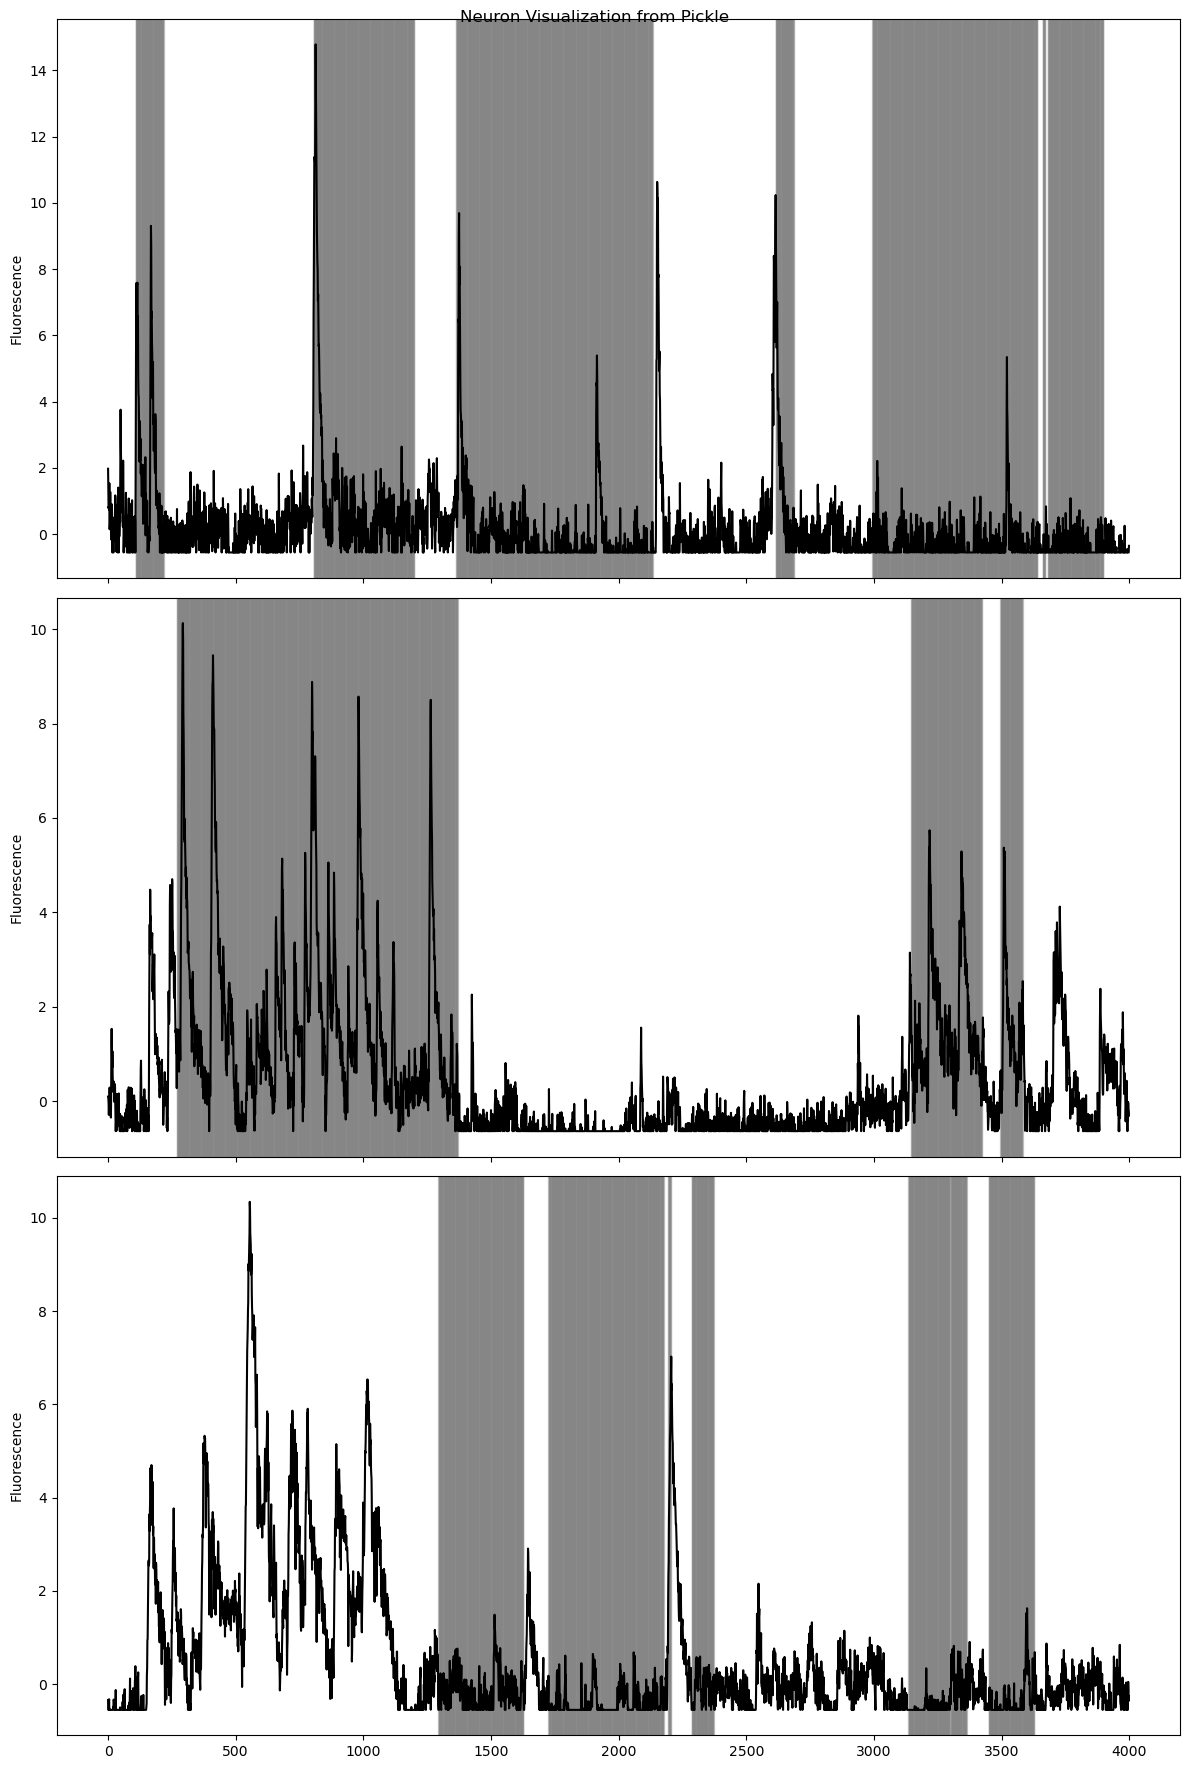

In [29]:
# Visualize from pickle
visualize_neuron_data(
    specific_neurons, 
    title_in="Neuron Visualization from Pickle"
)

Plot saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\day2_roc.svg and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\day2_roc.png


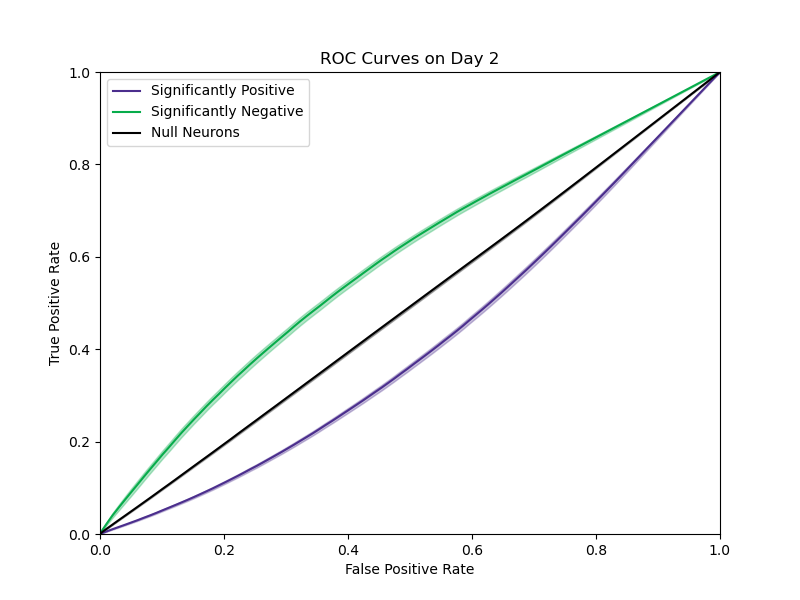

ROC curve data saved to CSV: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\day2_roc_roc_data.csv


In [30]:
def plot_significant_and_null_ROC_curves(
    all_neuron_data, day='day2', save_dir=None, filename=None, title_in=None
):
    positive_curves = []
    negative_curves = []
    null_curves = []

    csv_data = []  # To store data for the CSV

    for group, animals in all_neuron_data.items():
        for animal_id, days_data in animals.items():
            if day in days_data:
                p_values = days_data[day]['p_values']
                curves = days_data[day]['curves']

                for neuron_idx, (p_value, (fpr, tpr, thresholds)) in enumerate(zip(p_values, curves)):
                    curve = np.interp(np.linspace(0, 1, 100), fpr, tpr)
                    if p_value > 0.99:
                        positive_curves.append(curve)
                        label = 'positive'
                    elif p_value < 0.01:
                        negative_curves.append(curve)
                        label = 'negative'
                    else:
                        null_curves.append(curve)
                        label = 'null'
                    
                    # Save data to CSV
                    csv_data.append({
                        'Group': group,
                        'AnimalID': animal_id,
                        'NeuronIndex': neuron_idx,
                        'Label': label,
                        'Curve': list(curve)  # Convert curve to list for CSV compatibility
                    })

    # Compute mean and standard error for each category
    def compute_mean_and_se(curves):
        curves = np.array(curves)
        mean_curve = np.mean(curves, axis=0)
        se_curve = np.std(curves, axis=0) / np.sqrt(curves.shape[0])
        return mean_curve, se_curve

    if positive_curves:
        pos_mean, pos_se = compute_mean_and_se(positive_curves)
    else:
        pos_mean, pos_se = np.zeros(100), np.zeros(100)
        
    if negative_curves:
        neg_mean, neg_se = compute_mean_and_se(negative_curves)
    else:
        neg_mean, neg_se = np.zeros(100), np.zeros(100)
        
    if null_curves:
        null_mean, null_se = compute_mean_and_se(null_curves)
    else:
        null_mean, null_se = np.zeros(100), np.zeros(100)

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))

    x = np.linspace(0, 1, 100)
    ax.plot(x, pos_mean, label='Significantly Positive', color='#4B2E8D')
    ax.fill_between(x, pos_mean - pos_se, pos_mean + pos_se, color='#4B2E8D', alpha=0.3)

    ax.plot(x, neg_mean, label='Significantly Negative', color='#07AC4B')
    ax.fill_between(x, neg_mean - neg_se, neg_mean + neg_se, color='#07AC4B', alpha=0.3)

    ax.plot(x, null_mean, label='Null Neurons', color='black')
    ax.fill_between(x, null_mean - null_se, null_mean + null_se, color='black', alpha=0.3)

    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title_in if title_in else f'ROC Curves for Neurons on {day}')
    ax.legend()

    # Save the plot
    if save_dir and filename:
        os.makedirs(save_dir, exist_ok=True)
        save_path_svg = os.path.join(save_dir, filename + '.svg')
        save_path_png = os.path.join(save_dir, filename + '.png')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')
        print(f"Plot saved to {save_path_svg} and {save_path_png}")

    plt.show()

    # Save CSV data
    if save_dir and filename:
        csv_save_path = os.path.join(save_dir, filename + '_roc_data.csv')
        pd.DataFrame(csv_data).to_csv(csv_save_path, index=False)
        print(f"ROC curve data saved to CSV: {csv_save_path}")





plot_significant_and_null_ROC_curves(all_neuron_data, day='day2', save_dir=figDataSaveDir + '/imagingInhib_cells',
                                     filename='day2_roc', title_in='ROC Curves on Day 2')


### coregistered cells

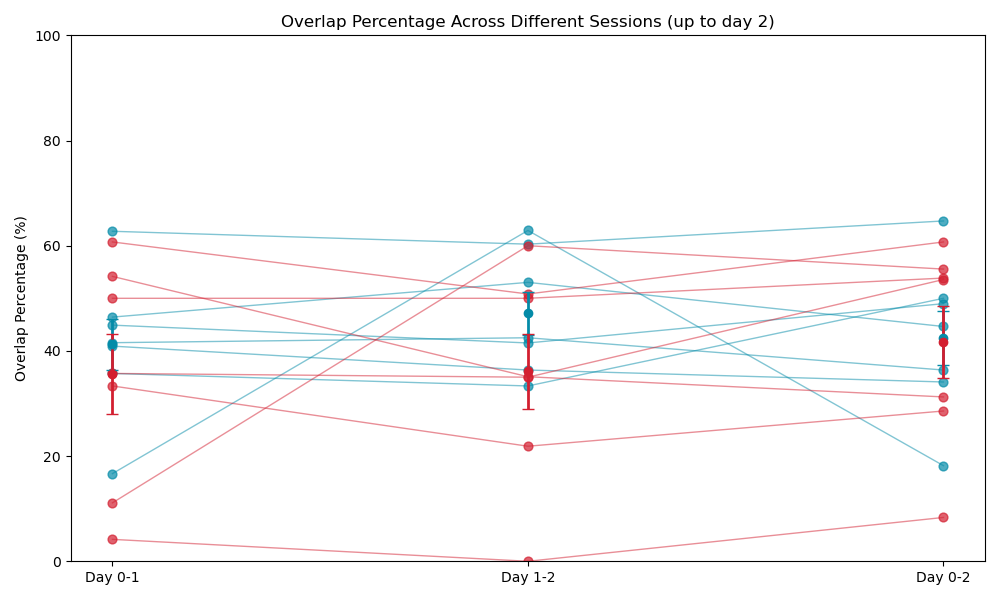

CSV saved: C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\cell_encoding_overlap_overlap_data.csv

Mixed-effects linear model results:
                  Mixed Linear Model Regression Results
Model:                  MixedLM       Dependent Variable:       Overlap  
No. Observations:       42            Method:                   REML     
No. Groups:             8             Scale:                    183.6049 
Min. group size:        3             Log-Likelihood:           -155.5628
Max. group size:        6             Converged:                Yes      
Mean group size:        5.2                                              
-------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------------------------
Intercept                     41.586    6.370  6.528 0.000  29.100 54.072
Gr

In [31]:
def plot_overlap_statistics(overlap_stats, save_dir, filename, data_groups, upto2=False):
    """Plot the means, standard errors, and individual data points of overlap percentages and save as CSV.
    Perform statistical comparisons between control and experimental groups.
    """

    # Prepare data for plotting and CSV
    csv_rows = []  # To store rows for the CSV
    group_colors = {'control': '#048BA8', 'expt': '#D31F30'}
    overlap_data = {'control': {}, 'expt': {}}

    for group in ['control', 'expt']:
        for animal, stats in overlap_stats[group].items():
            row = {'Group': group, 'Animal': animal, 'Day 0-1': np.nan, 'Day 1-2': np.nan, 'Day 0-2': np.nan, 'Day 2-14': np.nan}
            if animal not in overlap_data[group]:
                overlap_data[group][animal] = []

            if 'cellreg_0_2' in stats:
                row['Day 0-1'] = stats['cellreg_0_2']['overlap_percentage_0_1']
                row['Day 1-2'] = stats['cellreg_0_2']['overlap_percentage_1_2']
                row['Day 0-2'] = stats['cellreg_0_2']['overlap_percentage_0_2']
                overlap_data[group][animal].extend([
                    ('Day 0-1', stats['cellreg_0_2']['overlap_percentage_0_1']),
                    ('Day 1-2', stats['cellreg_0_2']['overlap_percentage_1_2']),
                    ('Day 0-2', stats['cellreg_0_2']['overlap_percentage_0_2'])
                ])
            if 'cellreg_2_14' in stats and not upto2:
                row['Day 2-14'] = stats['cellreg_2_14']['overlap_percentage_0_1']
                overlap_data[group][animal].append(('Day 2-14', stats['cellreg_2_14']['overlap_percentage_0_1']))
            csv_rows.append(row)

    # Convert data to a DataFrame for CSV
    csv_df = pd.DataFrame(csv_rows)

    # Prepare data for mixed-effects model
    stats_data = []
    for group in ['control', 'expt']:
        for animal, values in overlap_data[group].items():
            for day, value in values:
                if not np.isnan(value):
                    stats_data.append({'Animal': animal, 'Group': group, 'Day': day, 'Overlap': value})

    stats_df = pd.DataFrame(stats_data)

    # Calculate means and standard errors for plotting
    days = ['Day 0-1', 'Day 1-2', 'Day 0-2'] if upto2 else ['Day 0-1', 'Day 1-2', 'Day 0-2', 'Day 2-14']
    means = {
        group: {
            day: np.mean(
                [val for animal, values in overlap_data[group].items() for d, val in values if d == day]
            ) if overlap_data[group] else np.nan
            for day in days
        }
        for group in ['control', 'expt']
    }
    std_errs = {
        group: {
            day: np.std(
                [val for animal, values in overlap_data[group].items() for d, val in values if d == day]
            ) / np.sqrt(len(overlap_data[group])) if overlap_data[group] else np.nan
            for day in days
        }
        for group in ['control', 'expt']
    }

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot individual animal data
    for group in ['control', 'expt']:
        for animal, values in overlap_data[group].items():
            x_values = [v[0] for v in values]
            y_values = [v[1] for v in values]
            ax.plot(x_values, y_values, color=group_colors[group], alpha=0.5, zorder=1, linewidth=1)
            ax.scatter(x_values, y_values, color=group_colors[group], alpha=0.7, s=40, zorder=2)

    # Plot group means and standard errors
    for group in ['control', 'expt']:
        for day in days:
            mean = means[group][day]
            std_err = std_errs[group][day]
            ax.errorbar(day, mean, yerr=std_err, fmt='o', color=group_colors[group], ecolor=group_colors[group],
                        elinewidth=2, capsize=4, zorder=3)

    ax.set_ylabel('Overlap Percentage (%)')
    ax.set_title('Overlap Percentage Across Different Sessions' + (' (up to day 2)' if upto2 else ''))
    ax.set_xticks(days)
    ax.set_xticklabels(days)
    plt.ylim(0, 100)
    plt.tight_layout()

    # Save the plot
    os.makedirs(save_dir, exist_ok=True)
    save_path_svg = os.path.join(save_dir, filename + '.svg')
    plt.savefig(save_path_svg, format='svg')
    save_path_png = os.path.join(save_dir, filename + '.png')
    plt.savefig(save_path_png, format='png')

    plt.show()

    # Save the CSV
    csv_path = os.path.join(save_dir, filename + '_overlap_data.csv')
    csv_df.to_csv(csv_path, index=False)
    print(f"CSV saved: {csv_path}")

    # Mixed-effects linear model
    print("\nMixed-effects linear model results:")
    model = smf.mixedlm("Overlap ~ Group * Day", stats_df, groups=stats_df["Animal"])
    mixedlm_result = model.fit()
    print(mixedlm_result.summary())

    # Extract interaction term p-value and print in paper format
    interaction_term = "Group[T.expt]:Day[T.Day]"
    if interaction_term in mixedlm_result.pvalues:
        interaction_p_value = mixedlm_result.pvalues[interaction_term]
        print(f"Interaction (Group x Day): t(df) = X, p = {interaction_p_value:.3e}")

plot_overlap_statistics(overlap_stats, save_dir=figDataSaveDir + '/imagingInhib_cells', filename='cell_encoding_overlap', data_groups=data_groups_d2, upto2=True)

In [32]:
def calculate_overlap(preprocessed_data, day1_to_compare, day2_to_compare, num_shuffles=1000):
    """
    Calculate overlap percentages using preprocessed data.

    Args:
        preprocessed_data (dict): Preprocessed data loaded from the pickle file.
        day1_to_compare (str): The first day to compare (e.g., 'day0', 'day1').
        day2_to_compare (str): The second day to compare (e.g., 'day2', 'day14').
        index_type_day1 (str): Index type for day1 ('pos', 'neg', or 'total').
        index_type_day2 (str): Index type for day2 ('pos', 'neg', or 'total').
        num_shuffles (int): Number of shuffles for chance overlap calculation. Default is 100.

    Returns:
        dict: Overlap results with percentages, chance overlaps, and indices.
    """
    index_type_day1 = 'total'
    index_type_day2 = 'total'
    
    overlap_results = {'control': {}, 'expt': {}}
    day_indices = {'day0': 0, 'day1': 1, 'day2': 2, 'day14': 2}

    for group, animals in preprocessed_data.items():
        for animal_id, data in animals.items():
            cellreg_day1 = data['cellreg_day1']
            cellreg_day2 = data['cellreg_day2']

            # Check if cellreg_day1 and cellreg_day2 are valid arrays
            if not isinstance(cellreg_day1, np.ndarray) or cellreg_day1.size == 0:
                print(f"Skipping {animal_id} in {group}: cellreg_day1 is invalid or empty.")
                continue
            if not isinstance(cellreg_day2, np.ndarray) and not np.isnan(cellreg_day2):
                print(f"Skipping {animal_id} in {group}: cellreg_day2 is invalid.")
                continue

            # Determine column indices for day1 and day2
            day1_col = day_indices.get(day1_to_compare)
            day2_col = day_indices.get(day2_to_compare)

            if cellreg_day1.shape[1] <= day1_col:
                print(f"Skipping {animal_id} in {group}: cellreg_day1 does not have enough columns for {day1_to_compare}")
                continue
            if isinstance(cellreg_day2, np.ndarray) and cellreg_day2.shape[1] <= day2_col:
                print(f"Skipping {animal_id} in {group}: cellreg_day2 does not have enough columns for {day2_to_compare}")
                continue

            # Extract indices based on type
            day1_indices = data.get(f'{day1_to_compare}_{index_type_day1}_indices', [])
            day2_indices = data.get(f'{day2_to_compare}_{index_type_day2}_indices', [])

            # Ensure day1_indices and day2_indices are lists or arrays
            if not isinstance(day1_indices, (list, np.ndarray)) or not isinstance(day2_indices, (list, np.ndarray)):
                print(f"Skipping {animal_id} in {group}: invalid indices for {day1_to_compare} or {day2_to_compare}")
                continue

            if len(day1_indices) == 0 or len(day2_indices) == 0:
                print(f"Skipping {animal_id} in {group}: no valid indices for {day1_to_compare} or {day2_to_compare}")
                continue

            # Determine total co-registered cells
            if isinstance(cellreg_day2, np.ndarray):
                total_co_registered_cells = np.sum((cellreg_day1[:, day1_col] != 0) & (cellreg_day1[:, day2_col] != 0))
            else:
                total_co_registered_cells = np.sum((cellreg_day1[:, day1_col] != 0))

            # Calculate overlap
            overlapping_count = 0
            overlapping_indices_day1 = []
            overlapping_indices_day2 = []

            for cell_index in day1_indices:
                cell_mapped_to_day2 = cellreg_day1[cellreg_day1[:, day1_col] == (cell_index + 1), day2_col] - 1
                if cell_mapped_to_day2.size > 0 and cell_mapped_to_day2[0] in day2_indices:
                    overlapping_count += 1
                    overlapping_indices_day1.append(cell_index)
                    overlapping_indices_day2.append(cell_mapped_to_day2[0])

            overlap_percentage = overlapping_count / len(day1_indices) if len(day1_indices) > 0 else 0

            # Shuffle test for chance overlap
            shuffle_overlap_percentages = []
            for _ in range(num_shuffles):
                shuffled_day2_indices = np.random.choice(len(day2_indices), len(day2_indices), replace=False)
                shuffle_overlap_count = 0
                for cell_index in day1_indices:
                    cell_mapped_to_day2 = cellreg_day1[cellreg_day1[:, day1_col] == (cell_index + 1), day2_col] - 1
                    if cell_mapped_to_day2.size > 0 and cell_mapped_to_day2[0] in shuffled_day2_indices:
                        shuffle_overlap_count += 1
                shuffle_overlap_percentage = shuffle_overlap_count / len(day1_indices) if len(day1_indices) > 0 else 0
                shuffle_overlap_percentages.append(shuffle_overlap_percentage)

            expected_overlap_by_chance = np.mean(shuffle_overlap_percentages)

            # Store results
            overlap_results[group][animal_id] = {
                'overlap_percentage': overlap_percentage * 100,
                'expected_overlap_by_chance': expected_overlap_by_chance * 100,
                'total_co_registered_cells': total_co_registered_cells,
                'overlapping_count': overlapping_count,
                'overlapping_indices_day1': overlapping_indices_day1,
                'overlapping_indices_day2': overlapping_indices_day2,
            }

    return overlap_results

In [33]:
def plot_overlap_results(overlap_results, save_dir, filename, titleIn='default'):
    control_values = []
    experimental_values = []
    control_expected = []
    experimental_expected = []

    # Collecting data
    data_rows = []
    for group in ['control', 'expt']:
        for animal, result in overlap_results[group].items():
            if 'total_co_registered_cells' in result and result['total_co_registered_cells'] < 3:
                overlap_percentage = np.nan
                expected_chance = np.nan
            else:
                overlap_percentage = result['overlap_percentage']
                expected_chance = result['expected_overlap_by_chance']

            if group == 'control':
                control_values.append(overlap_percentage)
                control_expected.append(expected_chance)
            elif group == 'expt':
                experimental_values.append(overlap_percentage)
                experimental_expected.append(expected_chance)

            # Add row to data
            data_rows.append({
                'Animal': animal,
                'Group': group,
                'Observed Overlap (%)': overlap_percentage,
                'Expected Overlap (%)': expected_chance
            })

    # Perform Wilcoxon signed-rank test
    print("\nWilcoxon Signed-Rank Test Results:")
    
    # Filter out NaN values for control
    valid_control_indices = np.isfinite(control_values) & np.isfinite(control_expected)
    filtered_control_values = np.array(control_values)[valid_control_indices]
    filtered_control_expected = np.array(control_expected)[valid_control_indices]
    
    if len(filtered_control_values) > 0 and len(filtered_control_expected) > 0:
        stat_ctrl, p_val_ctrl = wilcoxon(filtered_control_values, filtered_control_expected)
        print(f"Control vs. Null: W({len(filtered_control_values)}) = {stat_ctrl:.8f}, p = {p_val_ctrl:.3e}")
    else:
        print("Control vs. Null: Not enough data for Wilcoxon test.")
    
    # Filter out NaN values for experimental
    valid_expt_indices = np.isfinite(experimental_values) & np.isfinite(experimental_expected)
    filtered_experimental_values = np.array(experimental_values)[valid_expt_indices]
    filtered_experimental_expected = np.array(experimental_expected)[valid_expt_indices]
    
    if len(filtered_experimental_values) > 0 and len(filtered_experimental_expected) > 0:
        stat_expt, p_val_expt = wilcoxon(filtered_experimental_values, filtered_experimental_expected)
        print(f"Experimental vs. Null: W({len(filtered_experimental_values)}) = {stat_expt:.8f}, p = {p_val_expt:.3e}")
    else:
        print("Experimental vs. Null: Not enough data for Wilcoxon test.")


    # Generate scatter positions
    jitterX = 0.025
    control_x = np.random.normal(1, jitterX, len(control_values))
    experimental_x = np.random.normal(2, jitterX, len(experimental_values))
    control_x_exp = np.random.normal(1.3, jitterX, len(control_expected))
    experimental_x_exp = np.random.normal(2.3, jitterX, len(experimental_expected))

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(control_x, control_values, color='#048BA8', label='Control Observed')
    ax.scatter(control_x_exp, control_expected, color='#048BA8', marker='x', label='Control Expected')
    ax.scatter(experimental_x, experimental_values, color='#D31F30', label='Experimental Observed')
    ax.scatter(experimental_x_exp, experimental_expected, color='#D31F30', marker='x', label='Experimental Expected')

    # Draw lines for observed to expected
    for i in range(len(control_values)):
        ax.plot([control_x[i], control_x_exp[i]], [control_values[i], control_expected[i]], color='gray', linestyle='--', linewidth=1)
    for i in range(len(experimental_values)):
        ax.plot([experimental_x[i], experimental_x_exp[i]], [experimental_values[i], experimental_expected[i]], color='gray', linestyle='--', linewidth=1)

    # Bars for mean values
    control_mean = np.nanmean(control_values)
    experimental_mean = np.nanmean(experimental_values)
    control_mean_exp = np.nanmean(control_expected)
    experimental_mean_exp = np.nanmean(experimental_expected)

    control_std_err = np.nanstd(control_values) / np.sqrt(len(control_values))
    experimental_std_err = np.nanstd(experimental_values) / np.sqrt(len(experimental_values))
    control_std_err_exp = np.nanstd(control_expected) / np.sqrt(len(control_expected))
    experimental_std_err_exp = np.nanstd(experimental_expected) / np.sqrt(len(experimental_expected))

    # Error bars
    ax.errorbar(1, control_mean, yerr=control_std_err, fmt='none', color='#048BA8', capsize=0, linewidth=2)
    ax.errorbar(1.3, control_mean_exp, yerr=control_std_err_exp, fmt='none', color='#048BA8', capsize=0, linewidth=2)
    ax.errorbar(2, experimental_mean, yerr=experimental_std_err, fmt='none', color='#D31F30', capsize=0, linewidth=2)
    ax.errorbar(2.3, experimental_mean_exp, yerr=experimental_std_err_exp, fmt='none', color='#D31F30', capsize=0, linewidth=2)

    # Bars for means
    ax.bar(1, control_mean, color='#048BA8', alpha=0.5, width=0.2)
    ax.bar(1.3, control_mean_exp, color='#048BA8', alpha=0.5, width=0.2)
    ax.bar(2, experimental_mean, color='#D31F30', alpha=0.5, width=0.2)
    ax.bar(2.3, experimental_mean_exp, color='#D31F30', alpha=0.5, width=0.2)

    ax.set_xticks([1.15, 2.15])
    ax.set_xticklabels(['Control', 'Experimental'])
    ax.set_ylabel('% Overlap out of all coregistered cells')
    ax.set_title(titleIn)
    ax.legend()

    plt.tight_layout()

    # Save the plot
    save_path_svg = os.path.join(save_dir, filename + '.svg')
    plt.savefig(save_path_svg, format='svg')
    save_path_png = os.path.join(save_dir, filename + '.png')
    plt.savefig(save_path_png, format='png')
    plt.show()

    # Save the data to CSV
    csv_path = os.path.join(save_dir, filename + '.csv')
    pd.DataFrame(data_rows).to_csv(csv_path, index=False)
    print(f"CSV saved to {csv_path}")

### encoding stability

Skipping animal3 in control: invalid indices for day0 or day2
Skipping animal5 in control: invalid indices for day0 or day2
Skipping animal10 in control: invalid indices for day0 or day2
Skipping animal5 in expt: invalid indices for day0 or day2
Skipping animal6 in expt: invalid indices for day0 or day2

Wilcoxon Signed-Rank Test Results:


C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\ephys\miniconda3\envs\caiman\lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Control vs. Null: W(6) = 0.00000000, p = 4.311e-02
Experimental vs. Null: W(5) = 1.00000000, p = 6.547e-01


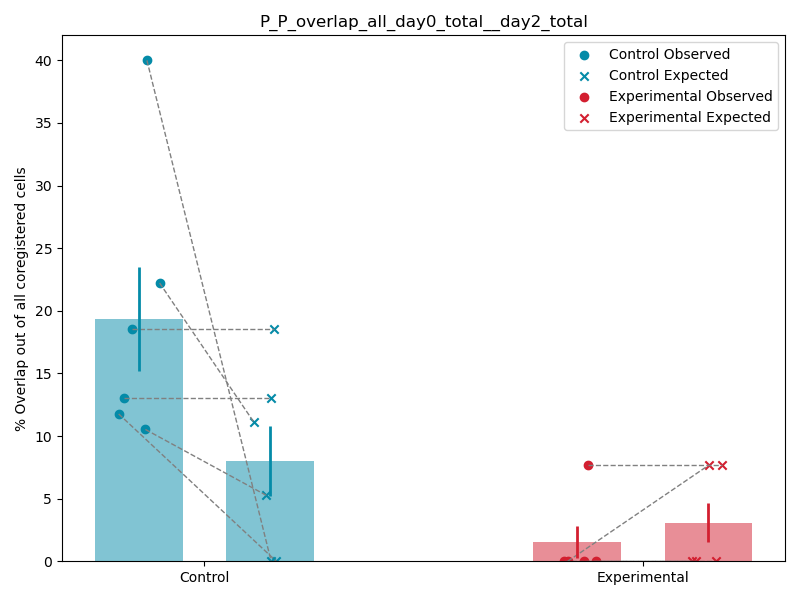

CSV saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\P_P_overlap_all_day0_total__day2_total.csv


In [34]:
day1_to_compare = 'day0'
day2_to_compare  = 'day2'
overlap_results_zero_two = calculate_overlap(preprocessed_stability_data, 
                                             day1_to_compare=day1_to_compare, 
                                             day2_to_compare=day2_to_compare)


Skipping animal10 in control: no valid indices for day0 or day1
Skipping animal7 in expt: no valid indices for day0 or day1

Wilcoxon Signed-Rank Test Results:
Control vs. Null: W(8) = 0.00000000, p = 2.771e-02
Experimental vs. Null: W(5) = 1.00000000, p = 6.547e-01


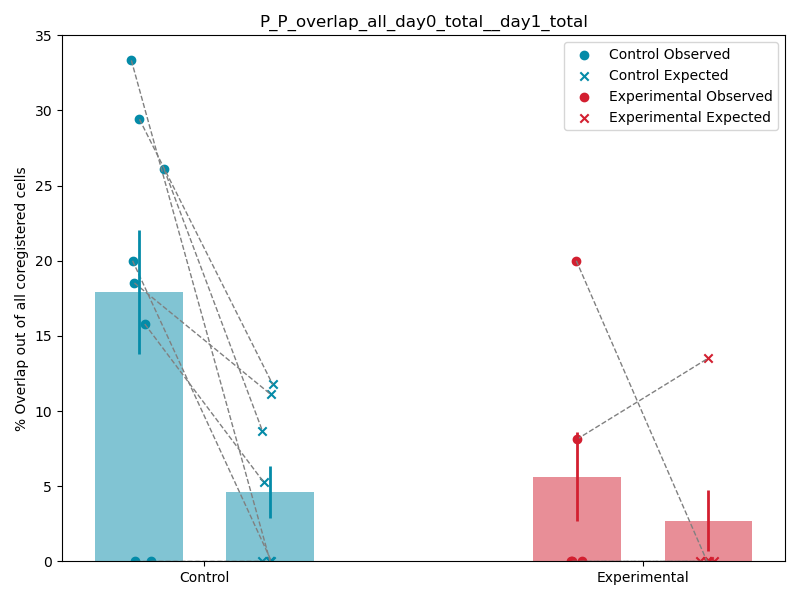

CSV saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\P_P_overlap_all_day0_total__day1_total.csv


In [35]:
day1_to_compare = 'day0'
day2_to_compare  = 'day1'
overlap_results_zero_one = calculate_overlap(preprocessed_stability_data, 
                                             day1_to_compare=day1_to_compare, 
                                             day2_to_compare=day2_to_compare)


Skipping animal3 in control: invalid indices for day1 or day2
Skipping animal5 in control: invalid indices for day1 or day2
Skipping animal10 in control: invalid indices for day1 or day2
Skipping animal5 in expt: invalid indices for day1 or day2
Skipping animal6 in expt: invalid indices for day1 or day2
Skipping animal7 in expt: no valid indices for day1 or day2

Wilcoxon Signed-Rank Test Results:
Control vs. Null: W(6) = 6.50000000, p = 7.865e-01
Experimental vs. Null: W(4) = 0.00000000, p = 3.173e-01


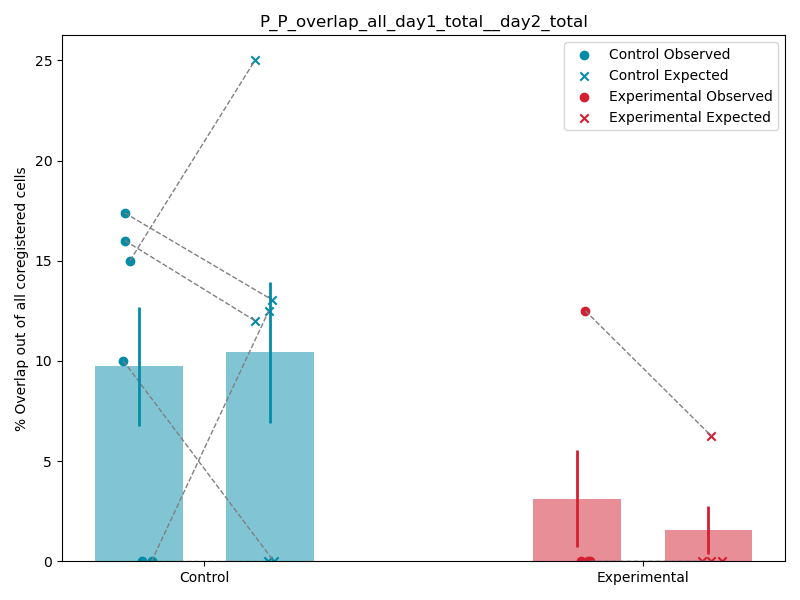

CSV saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells\P_P_overlap_all_day1_total__day2_total.csv


In [36]:
day1_to_compare = 'day1'
day2_to_compare  = 'day2'
overlap_results_one_two = calculate_overlap(preprocessed_stability_data, 
                                             day1_to_compare=day1_to_compare, 
                                             day2_to_compare=day2_to_compare)


In [37]:
def analyze_and_plot_stability(overlap_results_list, save_dir, filename='encoding_overlap', ymax=60):
    # Data preparation
    data_rows = []
    for results_entry in overlap_results_list:
        day_label = results_entry['day']
        results = results_entry['results']
        for group in ['control', 'expt']:
            for animal_id, result in results[group].items():
                row = {
                    'Animal': animal_id,
                    'Group': group,
                    'Day': day_label,
                    'Observed': result.get('overlap_percentage', np.nan),
                    'Chance': result.get('expected_overlap_by_chance', np.nan),
                }
                data_rows.append(row)
    
    df = pd.DataFrame(data_rows)
    colors = {'control': '#048BA8', 'expt': '#D31F30', 'shuffle': 'gray'}

    # Generate scatter plot for each group
    for group in ['control', 'expt']:
        group_df = df[df['Group'] == group]

        # Generate scatter positions
        jitterX = 0.025
        observed_x = []
        expected_x = []
        for day_idx, day in enumerate(['day0_1', 'day0_2', 'day1_2']):
            observed_x.extend(np.random.normal(day_idx + 1, jitterX, len(group_df[group_df['Day'] == day]['Observed'])))
            expected_x.extend(np.random.normal(day_idx + 1.3, jitterX, len(group_df[group_df['Day'] == day]['Chance'])))

        # Collect observed and chance values
        observed_values = group_df['Observed'].tolist()
        expected_values = group_df['Chance'].tolist()

        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(observed_x, observed_values, color=colors[group], label=f'{group.capitalize()} Observed')
        ax.scatter(expected_x, expected_values, color=colors['shuffle'], marker='x', label=f'Shuffle')

        # Draw lines connecting observed to chance
        for i in range(len(observed_values)):
            ax.plot([observed_x[i], expected_x[i]], 
                    [observed_values[i], expected_values[i]], 
                    color='gray', linestyle='--', linewidth=1)

        # Bars for mean values
        days = ['day0_1', 'day0_2', 'day1_2']
        means_observed = [group_df[group_df['Day'] == day]['Observed'].mean() for day in days]
        means_expected = [group_df[group_df['Day'] == day]['Chance'].mean() for day in days]
        std_errors_observed = [group_df[group_df['Day'] == day]['Observed'].std() / np.sqrt(len(group_df[group_df['Day'] == day])) for day in days]
        std_errors_expected = [group_df[group_df['Day'] == day]['Chance'].std() / np.sqrt(len(group_df[group_df['Day'] == day])) for day in days]

        for idx, day in enumerate(days):
            ax.errorbar(idx + 1, means_observed[idx], yerr=std_errors_observed[idx], fmt='none', color=colors[group], capsize=0, linewidth=2)
            ax.errorbar(idx + 1.3, means_expected[idx], yerr=std_errors_expected[idx], fmt='none', color=colors['shuffle'], capsize=0, linewidth=2)
            ax.bar(idx + 1, means_observed[idx], color=colors[group], alpha=0.5, width=0.2)
            ax.bar(idx + 1.3, means_expected[idx], color=colors['shuffle'], alpha=0.5, width=0.2)

        ax.set_xticks([1.15, 2.15, 3.15])
        ax.set_xticklabels(['Day 0-1', 'Day 0-2', 'Day 1-2'])
        ax.set_ylabel('% Overlap out of all coregistered cells')
        ax.set_title(f"{group.capitalize()} Observed vs. Shuffle")
        ax.set_ylim(-0.5, ymax)
        ax.legend()

        plt.tight_layout()

        # Save the plot
        os.makedirs(save_dir, exist_ok=True)
        save_path_svg = os.path.join(save_dir, f"{filename}_{group}.svg")
        plt.savefig(save_path_svg, format='svg')
        save_path_png = os.path.join(save_dir, f"{filename}_{group}.png")
        plt.savefig(save_path_png, format='png')
        plt.show()

    # Wilcoxon tests
    print("\nWilcoxon Signed-Rank Test Results:")
    for group in ['control', 'expt']:
        print(f"\nGroup: {group.capitalize()}")
        for day in ['day0_1', 'day0_2', 'day1_2']:
            observed = df[(df['Group'] == group) & (df['Day'] == day)]['Observed'].dropna()
            chance = df[(df['Group'] == group) & (df['Day'] == day)]['Chance'].dropna()

            if len(observed) > 0 and len(chance) > 0:
                stat, p_value = wilcoxon(observed, chance)
                n = len(observed)
                print(f"Day {day}: W({n}) = {stat:.8e}, p = {p_value:.3e}")
            else:
                print(f"Day {day}: Not enough data for Wilcoxon test.")

    return df


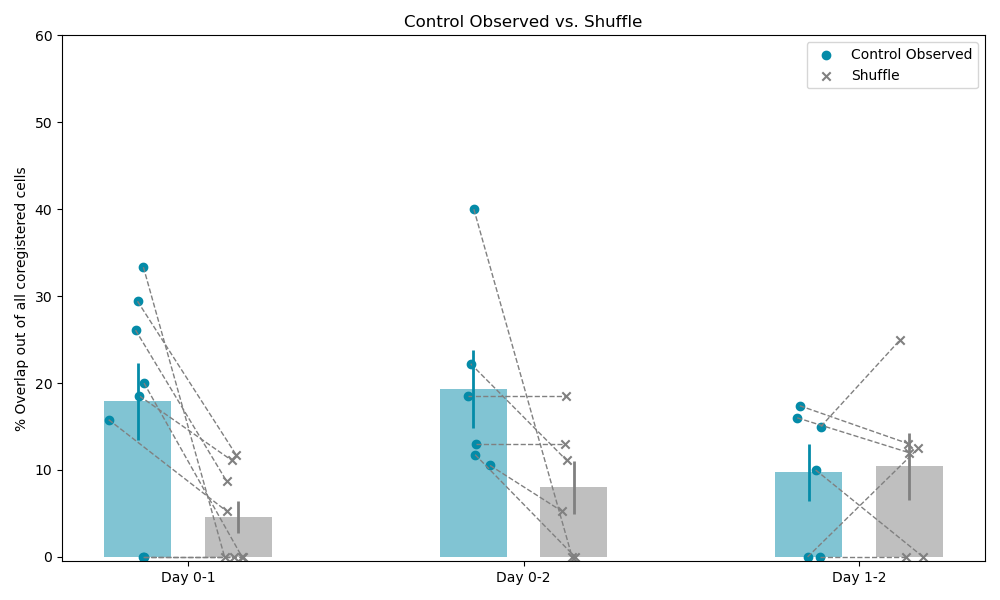

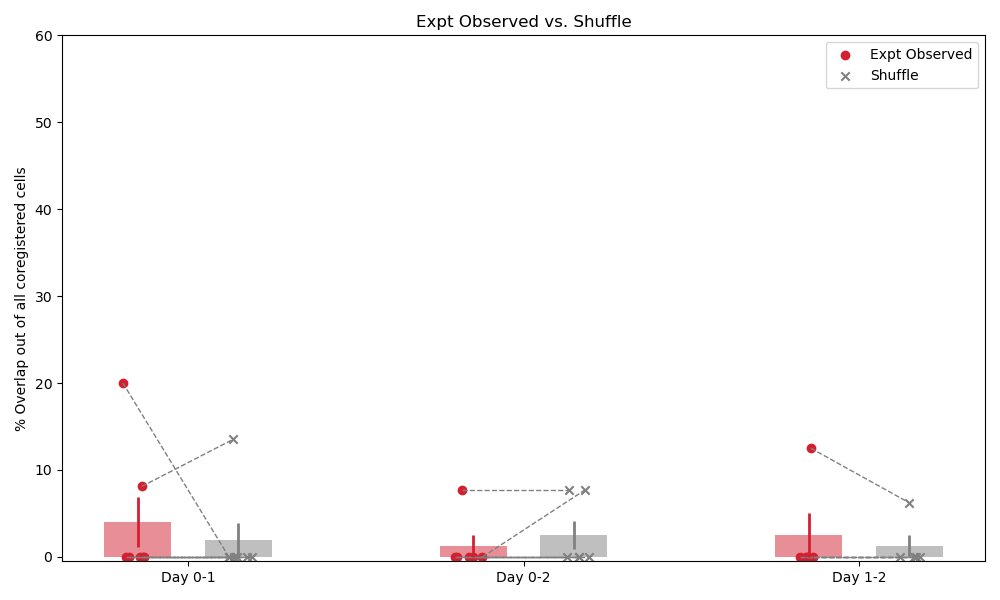


Wilcoxon Signed-Rank Test Results:

Group: Control
Day day0_1: W(8) = 0.00000000e+00, p = 2.771e-02
Day day0_2: W(6) = 0.00000000e+00, p = 4.311e-02
Day day1_2: W(6) = 6.50000000e+00, p = 7.865e-01

Group: Expt
Day day0_1: W(7) = 1.00000000e+00, p = 6.547e-01
Day day0_2: W(6) = 1.00000000e+00, p = 6.547e-01
Day day1_2: W(5) = 0.00000000e+00, p = 3.173e-01


,Animal,Group,Day,Observed,Chance
0,animal1,control,day0_1,0.000000,0.000000
1,animal2,control,day0_1,29.411765,11.764706
2,animal3,control,day0_1,0.000000,0.000000
3,animal4,control,day0_1,26.086957,8.695652
4,animal5,control,day0_1,33.333333,0.000000
5,animal7,control,day0_1,20.000000,0.000000
6,animal8,control,day0_1,18.518519,11.111111
7,animal9,control,day0_1,15.789474,5.263158
8,animal1,expt,day0_1,0.000000,0.000000
9,animal2,expt,day0_1,0.000000,0.000000


In [38]:

overlap_across_days = [
    {'day': 'day0_1', 'results': overlap_results_zero_one},
    {'day': 'day0_2', 'results': overlap_results_zero_two},
    {'day': 'day1_2', 'results': overlap_results_one_two},
]
analyze_and_plot_stability(overlap_across_days, save_dir=figDataSaveDir + '/imagingInhib_cells', filename='overlap_across_days')



### ROIs & cross registration examples

In [39]:
def plot_cell_footprints_with_outlines(
    data_groups, group, animal_id, day, title=None, marker_size=5, exclude_cells=None, 
    save_dir=None, filename=None, threshold=0.5, cmap='hsv', sigma=2):
    """
    Plot the maximum point of each cell's footprint on the template image and a second plot
    with pseudocolored cell ROIs on a white background with thin black outlines.

    Parameters:
    - data_groups: dict, the grouped data with spatial information
    - group: str, the group the animal belongs to ('control' or 'expt')
    - animal_id: str, the ID of the animal to plot
    - day: str, the day to plot (e.g., 'day2')
    - title: str, optional, the title of the plot
    - marker_size: int, size of the marker for the cell's maximum point
    - exclude_cells: list of int, cell indices to exclude from the plot
    - save_dir: str, directory to save the plots
    - filename: str, filename to save the plots
    - threshold: float, value to threshold the footprints for contour detection
    - cmap: str, Matplotlib colormap name for pseudocolor
    - sigma: float, standard deviation for Gaussian smoothing (default=1.5)
    """
    from scipy.ndimage import gaussian_filter
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import Normalize
    import os
    import cv2

    if exclude_cells is None:
        exclude_cells = []

    # Extract spatial data for the specified animal and day
    spatial_data = data_groups[group][animal_id][day].get('spatial_data')
    if not spatial_data:
        print(f"No spatial data found for {animal_id} on {day}")
        return

    dims_save = spatial_data['dims_save']
    spatial_save = spatial_data['spatial_save']
    template = spatial_data['template']
    height, width = dims_save

    # Initialize the plot
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))

    # Plot maximum points on the first subplot
    axs[0].imshow(template, cmap='gray', aspect='auto')
    axs[0].set_title('Max Positions')
    axs[0].axis('off')

    # Prepare white background for the second subplot
    outline_image = np.zeros((height, width))
    edge_image = np.zeros((height, width))

    for i in range(spatial_save.shape[1]):
        if i in exclude_cells:
            continue

        # Convert sparse matrix to dense array and reshape
        footprint_1d = spatial_save[:, i].toarray().ravel()
        footprint_2d = np.reshape(footprint_1d, (height, width), order='F')

        # Apply Gaussian smoothing to the footprint
        smoothed_footprint = gaussian_filter(footprint_2d, sigma=sigma)

        # Find the maximum point and plot it on the first subplot
        max_pos = np.unravel_index(np.argmax(smoothed_footprint), smoothed_footprint.shape)
        axs[0].plot(max_pos[1], max_pos[0], 'r*', markersize=marker_size)

        # Threshold the smoothed footprint
        roi_mask = (smoothed_footprint > (threshold * np.max(smoothed_footprint))).astype(np.uint8)

        # Find edges using cv2
        edges = cv2.Canny(roi_mask, 0, 1)
        edge_image[edges > 0] = 1

        # Assign a unique intensity value to this cell for pseudocolor mapping
        outline_image[roi_mask > 0] = i + 1

    # Randomize the color mapping
    unique_indices = np.unique(outline_image[outline_image > 0])
    np.random.shuffle(unique_indices)

    # Create a mapping from original indices to randomized ones
    random_index_mapping = {original: randomized 
                          for original, randomized in zip(np.arange(1, len(unique_indices) + 1), 
                                                        unique_indices)}

    # Remap the outline image based on randomized indices
    randomized_outline = np.zeros_like(outline_image)
    for original_index, randomized_index in random_index_mapping.items():
        randomized_outline[outline_image == original_index] = randomized_index

    # Apply colormap to the randomized indices
    norm = Normalize(vmin=1, vmax=spatial_save.shape[1])
    cmap_instance = plt.cm.get_cmap(cmap)
    pseudocolor_image = cmap_instance(norm(randomized_outline))[:, :, :3]

    # Create a white RGB background
    white_background = np.ones((height, width, 3))  # White background (all ones)
    
    # Add colored cells to white background
    white_background[randomized_outline > 0] = pseudocolor_image[randomized_outline > 0]
    
    # Add black edges
    white_background[edge_image > 0] = [0, 0, 0]  # Black color for edges

    # Plot the pseudocolored ROIs on the second subplot
    axs[1].imshow(white_background, aspect='auto')
    axs[1].set_title('Cell ROIs (Pseudocolor with Black Outlines)')
    axs[1].axis('off')

    if title:
        fig.suptitle(title)

    # Save the plot if save_dir and filename are provided
    if save_dir and filename:
        save_path_svg = os.path.join(save_dir, filename + '_outlines.svg')
        save_path_png = os.path.join(save_dir, filename + '_outlines.png')
        plt.savefig(save_path_svg, format='svg')
        plt.savefig(save_path_png, format='png')

    plt.show()




C:\Users\ephys\AppData\Local\Temp\ipykernel_27680\4003906169.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_instance = plt.cm.get_cmap(cmap)


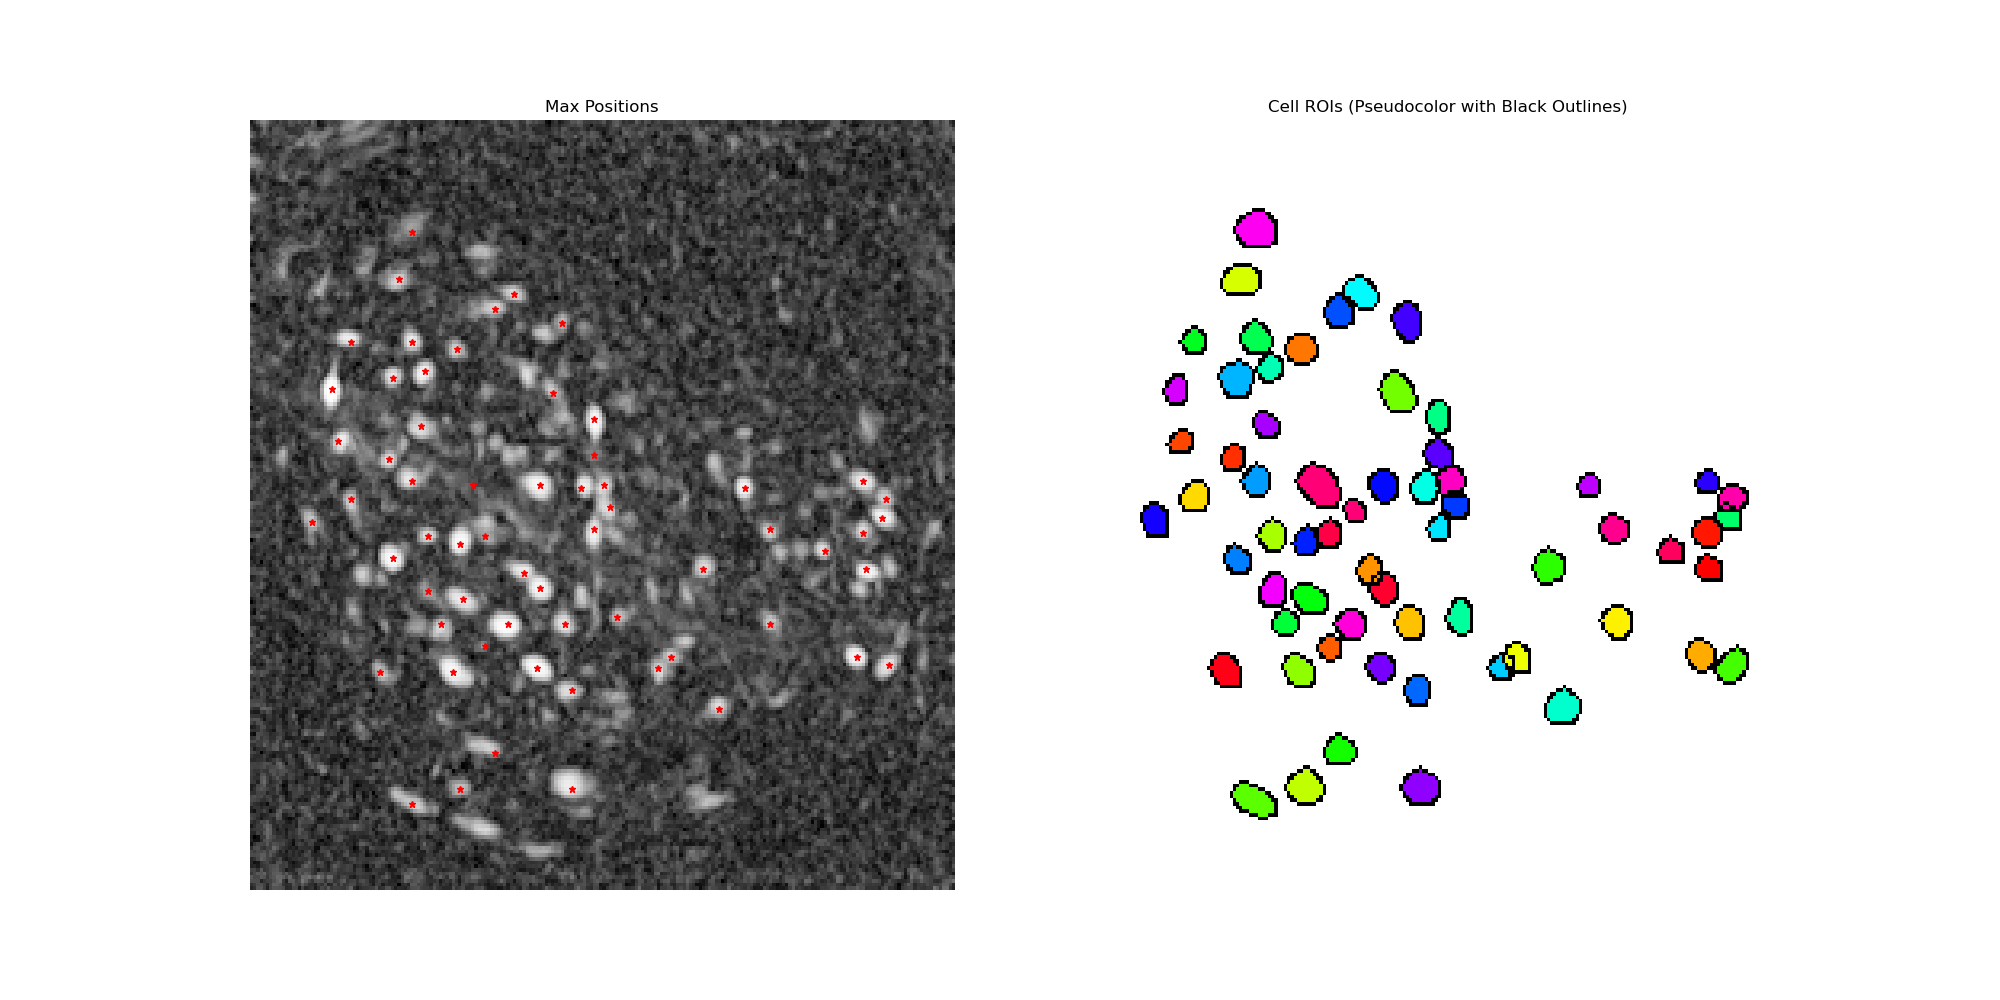

In [40]:
plot_cell_footprints_with_outlines(data_groups_d01, group='expt',
                              animal_id='animal6',day='day0', 
                              marker_size=5, 
                              save_dir=figDataSaveDir + '/imagingInhib_cells', 
                              filename='single_FOV_cells_example', cmap='hsv')



C:\Users\ephys\AppData\Local\Temp\ipykernel_27680\3385601493.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', num_cells)


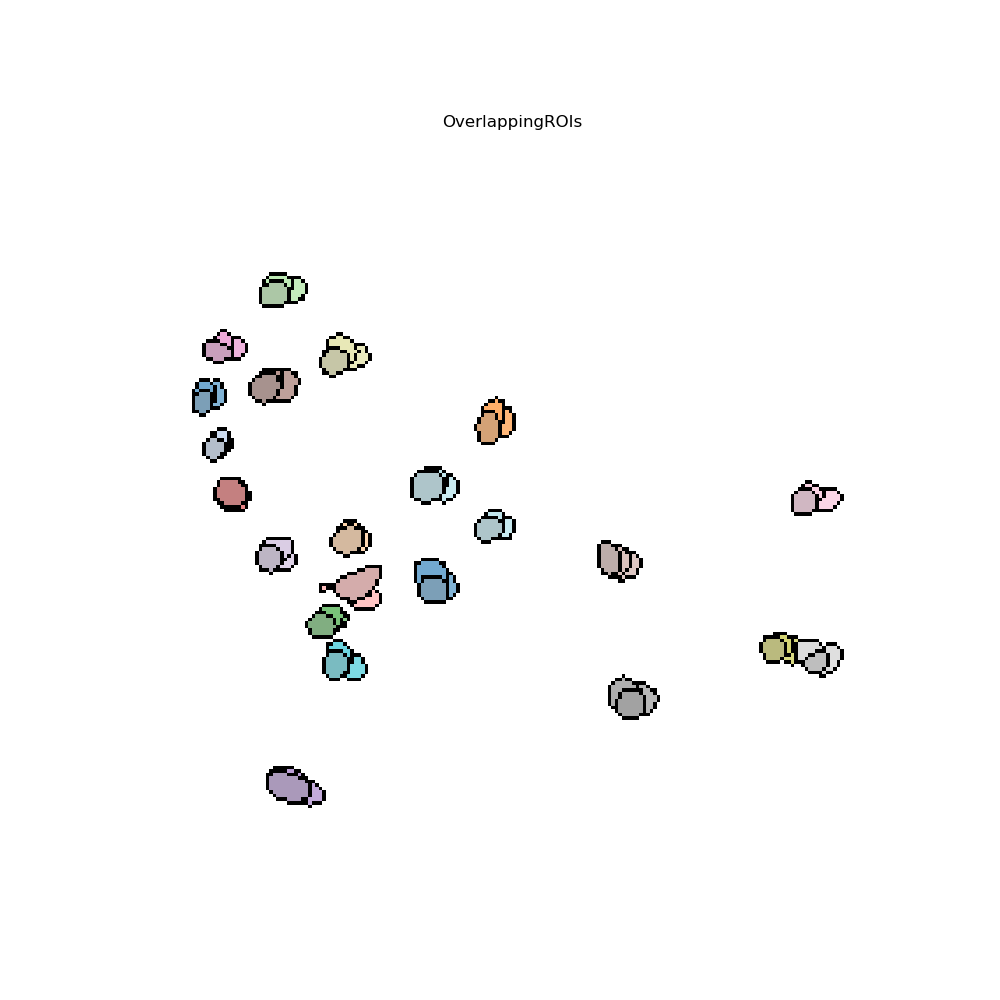

In [41]:
def plot_cell_footprints_over_time(
    data_groups, group, animal_id, title=None, exclude_cells=None, 
    save_dir=None, filename=None, sigma=1.5, threshold=0.5, alpha=0.7):
    """
    Plot the ROIs of cells across three days with transparent overlapping layers
    and consistent base colors for each cell.

    Parameters:
    - data_groups: dict, the grouped data with spatial and cellreg information
    - group: str, the group the animal belongs to ('control' or 'expt')
    - animal_id: str, the ID of the animal to plot
    - title: str, optional, the title of the plot
    - exclude_cells: list of int, cell indices to exclude from the plot
    - save_dir: str, directory to save the plot
    - filename: str, filename to save the plot
    - sigma: float, standard deviation for Gaussian smoothing (default=1.5)
    - threshold: float, value to threshold the footprints (default=0.5)
    - alpha: float, base transparency value (default=0.7)
    """
    if exclude_cells is None:
        exclude_cells = []
    
    days = ['day0', 'day1', 'day2']
    
    if 'cellreg_0_2' not in data_groups[group][animal_id]:
        raise ValueError(f"Missing cellreg_0_2 for animal {animal_id} in group {group}")
    
    cell_map = data_groups[group][animal_id]['cellreg_0_2']
    
    # Find cells present in all three sessions
    cells_present_all_days = cell_map[(cell_map[:, 0] > 0) & (cell_map[:, 1] > 0) & (cell_map[:, 2] > 0)]
    cells_present_session_0 = cells_present_all_days[:, 0].astype(int) - 1
    cells_present_session_0 = [cell for cell in cells_present_session_0 if cell not in exclude_cells]

    # Prepare the white background
    spatial_data_day0 = data_groups[group][animal_id]['day0']['spatial_data']
    height, width = spatial_data_day0['dims_save']
    
    # Initialize RGBA image with white background
    final_image = np.ones((height, width, 4))  # RGBA
    
    # Generate unique colors for each cell
    num_cells = len(cells_present_session_0)
    cmap = plt.cm.get_cmap('tab20', num_cells)
    shuffled_indices = np.random.permutation(num_cells)
    cell_colors = [cmap(i) for i in shuffled_indices]

    def get_thin_edges(mask):
        """Helper function to get thin edges from a binary mask"""
        # Convert to uint8
        mask_uint8 = mask.astype(np.uint8)
        
        # Find contours - this gives single-pixel edges
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Draw contours on empty image
        edges = np.zeros_like(mask_uint8)
        cv2.drawContours(edges, contours, -1, 1, 1)  # thickness=1
        
        return edges > 0

    # Process each cell
    for cell_idx, cell in enumerate(cells_present_session_0):
        # Create a separate RGBA image for this cell
        cell_image = np.zeros((height, width, 4))
        base_color = np.array(cell_colors[cell_idx])
        
        # Process each day for this cell
        for day_idx, day in enumerate(days):
            spatial_data_day = data_groups[group][animal_id][day]['spatial_data']
            spatial_save_day = spatial_data_day['spatial_save']
            cell_index = cells_present_all_days[cell_idx, day_idx].astype(int) - 1
            
            # Get and process the footprint
            footprint_1d = spatial_save_day[:, cell_index].toarray().ravel()
            footprint_2d = np.reshape(footprint_1d, (height, width), order='F')
            smoothed_footprint = gaussian_filter(footprint_2d, sigma=sigma)
            
            # Threshold and create mask
            roi_mask = (smoothed_footprint > threshold * np.max(smoothed_footprint))
            
            # Get thin edges
            edges = get_thin_edges(roi_mask)
            
            # Adjust color for this day
            day_color = base_color.copy()
            # Modify both color and alpha for different days
            if day_idx == 0:  # First day - lightest
                day_color[:3] = base_color[:3] * 0.8 + 0.2  # Lighter
                day_alpha = alpha
            elif day_idx == 1:  # Second day - medium
                day_color[:3] = base_color[:3]
                day_alpha = alpha * 0.9
            else:  # Third day - darkest
                day_color[:3] = base_color[:3] * 0.7  # Darker
                day_alpha = alpha * 0.8
            
            # Add the ROI to the cell image
            for c in range(4):  # RGBA channels
                if c < 3:  # RGB channels
                    cell_image[roi_mask, c] = day_color[c]
                else:  # Alpha channel
                    cell_image[roi_mask, c] = day_alpha
            
            # Add pure black edges with full opacity
            cell_image[edges] = [0, 0, 0, 1]  # Pure black, full opacity

        # Composite this cell onto the final image
        # Only update pixels where this cell has some opacity
        mask = cell_image[:, :, 3] > 0
        final_image[mask] = cell_image[mask]

    # Plot the combined ROIs
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(final_image)
    ax.axis('off')
    
    if title:
        ax.set_title(title)

    # Save the plot if save_dir and filename are provided
    if save_dir and filename:
        save_path_svg = os.path.join(save_dir, filename + '.svg')
        save_path_png = os.path.join(save_dir, filename + '.png')
        plt.savefig(save_path_svg, format='svg', transparent=True)
        plt.savefig(save_path_png, format='png', transparent=True)

    plt.show()
plot_cell_footprints_over_time(
    data_groups=data_groups_d01,
    group='expt',
    animal_id='animal6',
    title='OverlappingROIs',
    save_dir=figDataSaveDir + '/imagingInhib_cells',
    filename='registration_across_days_example',
    sigma = 2
)




### spatial clustering, auroc neurons

In [42]:
def calculate_pairwise_distances(cells):
    """Calculate the pairwise Euclidean distances between cells."""
    return pdist(cells, metric='euclidean')

def shuffle_and_calculate_distances(cells, n_selected, n_shuffles=1000):
    """Shuffle cell labels and calculate pairwise distances for a random subset of cells."""
    shuffled_distances = []
    for _ in range(n_shuffles):
        shuffled_indices = np.random.choice(len(cells), n_selected, replace=False)
        shuffled_cells = cells[shuffled_indices]
        distances = calculate_pairwise_distances(shuffled_cells)
        shuffled_distances.append(np.mean(distances))
    return shuffled_distances

def identify_outliers(observed_distance, shuffled_distances):
    """Identify if observed distance is outside the 5% or 95% of the shuffle distribution."""
    lower_bound = np.percentile(shuffled_distances, 5)
    upper_bound = np.percentile(shuffled_distances, 95)
    percentile = (np.sum(np.array(shuffled_distances) < observed_distance) / len(shuffled_distances)) * 100
    
    if observed_distance < lower_bound:
        return 'below 5%', percentile
    elif observed_distance > upper_bound:
        return 'above 95%', percentile
    else:
        return 'within range', percentile

def analyze_spatial_clustering(day2_14_auROCs, data_groups, use_total_indices=False):
    results = {'control': {}, 'expt': {}}
    for group_name in ['control', 'expt']:
        for animal_id in day2_14_auROCs[group_name]:
            if 'day2' in day2_14_auROCs[group_name][animal_id]:
                # Get pos_indices and neg_indices for day2
                pos_indices = day2_14_auROCs[group_name][animal_id]['day2']['pos_indices']
                neg_indices = day2_14_auROCs[group_name][animal_id]['day2']['neg_indices']
                
                if use_total_indices:
                    indices_to_use = list(set(pos_indices + neg_indices))
                else:
                    indices_to_use = pos_indices

                # Extract spatial_save and dims_save from data_groups
                spatial_save = data_groups[group_name][animal_id]['day2']['spatial_data']['spatial_save']
                dims_save = data_groups[group_name][animal_id]['day2']['spatial_data']['dims_save']
                height, width = dims_save  # Assuming dims_save contains the imaging frame dimensions
                
                # Get the 2D positions of all cells
                all_cells = []
                for i in range(spatial_save.shape[1]):
                    footprint_1d = spatial_save[:, i].toarray().ravel()
                    expected_size = height * width
                    if footprint_1d.size != expected_size:
                        if footprint_1d.size % expected_size != 0:
                            print(f"Skipping neuron {i}: cannot reshape array of size {footprint_1d.size} into shape ({height}, {width})")
                            continue
                        footprint_1d = footprint_1d[:expected_size]
                    footprint_2d = np.reshape(footprint_1d, (height, width), order='F')
                    max_pos = np.unravel_index(np.argmax(footprint_2d), footprint_2d.shape)
                    all_cells.append(max_pos)
                
                all_cells = np.array(all_cells)
                
                # Adjust indices to be 0-based and valid
                valid_indices = [i for i in indices_to_use if 0 <= i < len(all_cells)]
                selected_cells = all_cells[valid_indices]
                
                if len(selected_cells) > 2:
                    # Calculate observed pairwise distances
                    observed_distances = calculate_pairwise_distances(selected_cells)
                    observed_mean_distance = np.mean(observed_distances)
                    
                    # Shuffle all cells and calculate pairwise distances
                    shuffled_distances = shuffle_and_calculate_distances(all_cells, len(selected_cells))
                    
                    # Identify if the observed mean distance is an outlier and get its percentile
                    _, percentile = identify_outliers(observed_mean_distance, shuffled_distances)
                else:
                    percentile = None

                results[group_name][animal_id] = {
                    'percentile': percentile
                }
    
    return results

def plot_spatial_clustering_results(results, save_dir=None, filename_prefix=None):
    control_percentiles = []
    experimental_percentiles = []

    print("Results of Spatial Clustering Analysis:")
    for group_name in results:
        print(f"\nGroup: {group_name.capitalize()}")
        for animal_id, result in results[group_name].items():
            percentile = result['percentile']
            if percentile is not None:
                print(f"Animal {animal_id}: Percentile: {percentile:.2f}%")
                if group_name == 'control':
                    control_percentiles.append(percentile)
                elif group_name == 'expt':
                    experimental_percentiles.append(percentile)
            else:
                print(f"Animal {animal_id}: not enough cells for analysis")

    # CDF Plot
    sorted_control = np.sort(control_percentiles)
    sorted_experimental = np.sort(experimental_percentiles)
    y_control = np.arange(1, len(sorted_control) + 1) / len(sorted_control)
    y_experimental = np.arange(1, len(sorted_experimental) + 1) / len(sorted_experimental)

    fig_cdf, ax_cdf = plt.subplots(figsize=(8, 6))
    ax_cdf.plot(sorted_control, y_control, marker='o', linestyle='-', color='#128CA8', label='Control')
    ax_cdf.plot(sorted_experimental, y_experimental, marker='o', linestyle='-', color='#CC2028', label='Experimental')

    ax_cdf.set_title('CDF of Spatial Clustering Percentiles')
    ax_cdf.set_xlabel('Percentile')
    ax_cdf.set_ylabel('Cumulative Probability')
    ax_cdf.axvline(50, color='gray', linestyle='--')
    ax_cdf.set_xlim(0, 100)
    ax_cdf.legend()

    plt.tight_layout()

    if save_dir and filename_prefix:
        cdf_save_path = os.path.join(save_dir, f'{filename_prefix}_cdf.png')
        plt.savefig(cdf_save_path)
        cdf_save_path_svg = os.path.join(save_dir, f'{filename_prefix}_cdf.svg')
        plt.savefig(cdf_save_path_svg, format='svg')
        print(f"CDF plot saved as {cdf_save_path} and {cdf_save_path_svg}")

    plt.show()

    # Save data being plotted as CSV
    if save_dir and filename_prefix:
        csv_data = {
            'Group': ['Control'] * len(control_percentiles) + ['Experimental'] * len(experimental_percentiles),
            'Percentile': control_percentiles + experimental_percentiles
        }
        csv_path = os.path.join(save_dir, f"{filename_prefix}_data.csv")
        pd.DataFrame(csv_data).to_csv(csv_path, index=False)
        print(f"Data saved as {csv_path}")

    # Perform t-tests
    t_stat_control, p_val_control = ttest_1samp(control_percentiles, 50)
    t_stat_expt, p_val_expt = ttest_1samp(experimental_percentiles, 50)
    
    # Print results in paper-friendly format
    print("\nStatistical Tests:")
    print(f"Control vs. Null: t({len(control_percentiles) - 1}) = {t_stat_control:.2f}, p = {p_val_control:.3e}")
    print(f"Experimental vs. Null: t({len(experimental_percentiles) - 1}) = {t_stat_expt:.2f}, p = {p_val_expt:.3e}")

    # Save the statistical results to a text file
    if save_dir and filename_prefix:
        stats_file_path = os.path.join(save_dir, f"{filename_prefix}_stats.txt")
        with open(stats_file_path, 'w') as f:
            f.write("Spatial Clustering Analysis\n")
            f.write(f"Control vs. Null: t({len(control_percentiles) - 1}) = {t_stat_control:.2f}, p = {p_val_control:.3e}\n")
            f.write(f"Experimental vs. Null: t({len(experimental_percentiles) - 1}) = {t_stat_expt:.2f}, p = {p_val_expt:.3e}\n")
        print(f"Statistical results saved to {stats_file_path}")


Results of Spatial Clustering Analysis:

Group: Control
Animal animal1: not enough cells for analysis
Animal animal2: not enough cells for analysis
Animal animal3: not enough cells for analysis
Animal animal4: Percentile: 25.30%
Animal animal5: not enough cells for analysis
Animal animal6: not enough cells for analysis
Animal animal7: Percentile: 71.50%
Animal animal8: Percentile: 60.40%

Group: Expt
Animal animal1: Percentile: 37.70%
Animal animal2: Percentile: 15.00%
Animal animal3: Percentile: 50.70%
Animal animal4: Percentile: 80.60%
Animal animal5: Percentile: 8.50%
Animal animal6: not enough cells for analysis
Animal animal7: not enough cells for analysis
CDF plot saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_partner_aurocs_cdf.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_partner

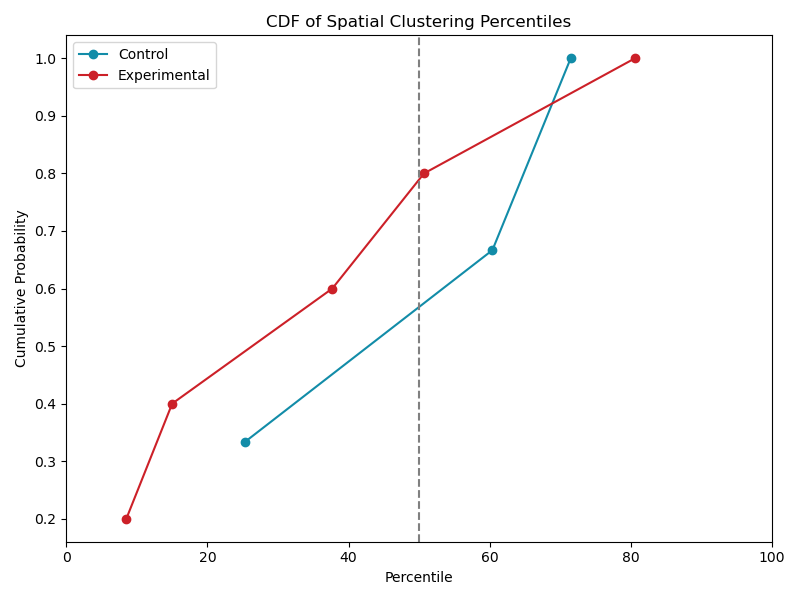

Data saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_partner_aurocs_data.csv

Statistical Tests:
Control vs. Null: t(2) = 0.17, p = 8.790e-01
Experimental vs. Null: t(4) = -0.89, p = 4.260e-01
Statistical results saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_partner_aurocs_stats.txt


In [43]:
results = analyze_spatial_clustering(day2_14_auROCs_partner, data_groups_d2)
plot_spatial_clustering_results(results, save_dir=figDataSaveDir + '/imagingInhib_cells_supp', filename_prefix='spatial_clustering_partner_aurocs')

Results of Spatial Clustering Analysis:

Group: Control
Animal animal1: Percentile: 38.70%
Animal animal2: Percentile: 73.50%
Animal animal3: Percentile: 98.80%
Animal animal4: Percentile: 12.50%
Animal animal5: Percentile: 33.10%
Animal animal6: Percentile: 0.20%
Animal animal7: Percentile: 53.20%
Animal animal8: Percentile: 58.90%

Group: Expt
Animal animal1: Percentile: 70.30%
Animal animal2: not enough cells for analysis
Animal animal3: not enough cells for analysis
Animal animal4: Percentile: 58.00%
Animal animal5: not enough cells for analysis
Animal animal6: not enough cells for analysis
Animal animal7: not enough cells for analysis
CDF plot saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_novel_aurocs_cdf.png and C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_novel_aurocs_cdf.svg


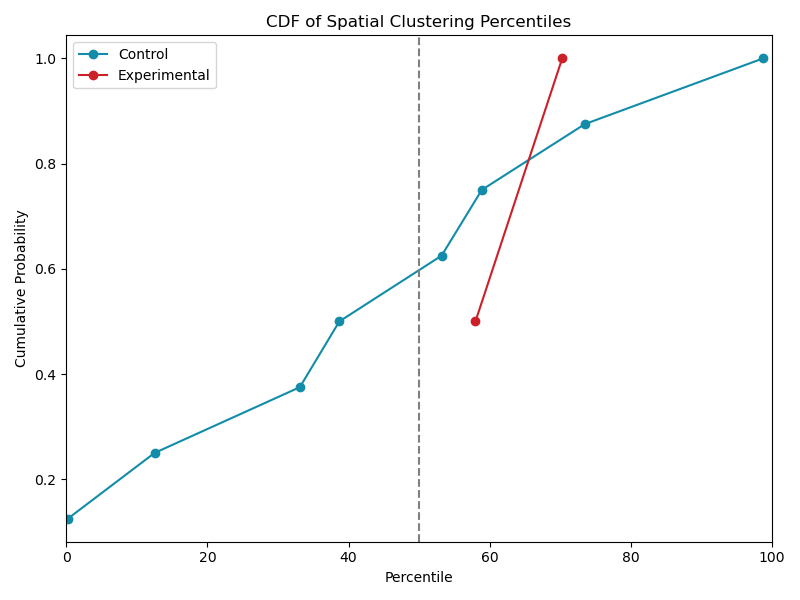

Data saved as C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_novel_aurocs_data.csv

Statistical Tests:
Control vs. Null: t(7) = -0.34, p = 7.418e-01
Experimental vs. Null: t(1) = 2.30, p = 2.610e-01
Statistical results saved to C:\code\miniscope-analysis-mek\InterneuronInhibNAc\InterneuronInhibNAc\figs\paper_figs\fig_data/imagingInhib_cells_supp\spatial_clustering_novel_aurocs_stats.txt


In [44]:
results = analyze_spatial_clustering(day2_14_auROCs_novel, data_groups_d2)
plot_spatial_clustering_results(results, save_dir=figDataSaveDir + '/imagingInhib_cells_supp', filename_prefix='spatial_clustering_novel_aurocs')

In [45]:
def plot_spatial_footprints(data_groups_d2, day2_14_auROCs, day2_14_auROCs_novel, 
                       plot_type=None, save_dir=None, plotSpecific=None, sigma=1.5, threshold=0.5):
    """
    Plot spatial footprints of partner and novel neurons with filled ROIs and black outlines.
    """
    from scipy.ndimage import gaussian_filter
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import colors
    import cv2
    import os

    # Set consistent colors
    partner_color = '#128CA8'  # matches control color
    novel_color = '#CC2028'    # matches experiment color

    def get_thin_edges(mask):
        """Helper function to get thin edges from a binary mask"""
        mask_uint8 = mask.astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        edges = np.zeros_like(mask_uint8)
        cv2.drawContours(edges, contours, -1, 1, 1)  # thickness=1
        return edges > 0

    # Parse plotSpecific if provided
    specific_group = None
    specific_animal = None
    if plotSpecific:
        parts = plotSpecific.split('_')
        if len(parts) == 2 and parts[0] in ['control', 'expt']:
            specific_group = parts[0]
            specific_animal = parts[1]

    for group_name in ['control', 'expt']:
        if specific_group and group_name != specific_group:
            continue

        for animal_id in day2_14_auROCs[group_name]:
            if specific_animal and animal_id != specific_animal:
                continue

            if 'day2' in day2_14_auROCs[group_name][animal_id]:
                # Get pos_indices for partner and novel
                partner_pos_indices = day2_14_auROCs[group_name][animal_id]['day2']['pos_indices']
                novel_pos_indices = day2_14_auROCs_novel[group_name][animal_id]['day2']['pos_indices']
                
                # Extract spatial data
                spatial_data = data_groups_d2[group_name][animal_id]['day2']['spatial_data']
                spatial_save = spatial_data['spatial_save']
                dims_save = spatial_data['dims_save']
                height, width = dims_save

                # Create figure
                fig, ax = plt.subplots(figsize=(10, 10))

                # Initialize image for ROIs (white background)
                colored_image = np.ones((height, width, 4))  # RGBA
                edge_image = np.zeros((height, width))

                # Process each cell
                for i in range(spatial_save.shape[1]):
                    footprint_1d = spatial_save[:, i].toarray().ravel()
                    footprint_2d = np.reshape(footprint_1d, (height, width), order='F')
                    
                    # Apply Gaussian smoothing
                    smoothed_footprint = gaussian_filter(footprint_2d, sigma=sigma)
                    
                    # Threshold and create mask
                    roi_mask = (smoothed_footprint > threshold * np.max(smoothed_footprint))
                    
                    if roi_mask.any():  # Only process if we have a valid ROI
                        # Get edges
                        edges = get_thin_edges(roi_mask.astype(np.uint8))
                        edge_image[edges] = 1
                        
                        # Set color based on neuron type
                        if i in partner_pos_indices and (plot_type is None or plot_type == 'partner'):
                            color = np.array(list(colors.to_rgba(partner_color)))
                            colored_image[roi_mask] = color
                        
                        elif i in novel_pos_indices and (plot_type is None or plot_type == 'novel'):
                            color = np.array(list(colors.to_rgba(novel_color)))
                            colored_image[roi_mask] = color

                # Add black edges to the colored image
                for c in range(3):  # RGB channels
                    colored_image[edge_image > 0, c] = 0  # Black color
                colored_image[edge_image > 0, 3] = 1  # Full opacity for edges

                # Plot the colored ROIs
                ax.imshow(colored_image)
                ax.axis('off')

                # Set title
                ax.set_title(f'{group_name.capitalize()} Animal {animal_id} - Day 2')
                
                # Save the plot if save_dir is provided
                if save_dir:
                    os.makedirs(save_dir, exist_ok=True)
                    filename = f'aurocs_spatial_{group_name}_animal_{animal_id}_day2'
                    if plot_type:
                        filename += f'_{plot_type}'
                    
                    plt.savefig(f'{save_dir}/{filename}.png', dpi=300, bbox_inches='tight')
                    plt.savefig(f'{save_dir}/{filename}.svg', format='svg', bbox_inches='tight')
                
                plt.show()

                # Print statistics
                print(f"\n{group_name.capitalize()} Animal {animal_id} - Day 2:")
                print(f"Partner neurons: {len(partner_pos_indices)}")
                print(f"Novel neurons: {len(novel_pos_indices)}")
                print(f"Total neurons: {spatial_save.shape[1]}")
                print(f"Percent partner: {len(partner_pos_indices)/spatial_save.shape[1]*100:.1f}%")
                print(f"Percent novel: {len(novel_pos_indices)/spatial_save.shape[1]*100:.1f}%")

            if specific_animal:
                break
        if specific_animal:
            break

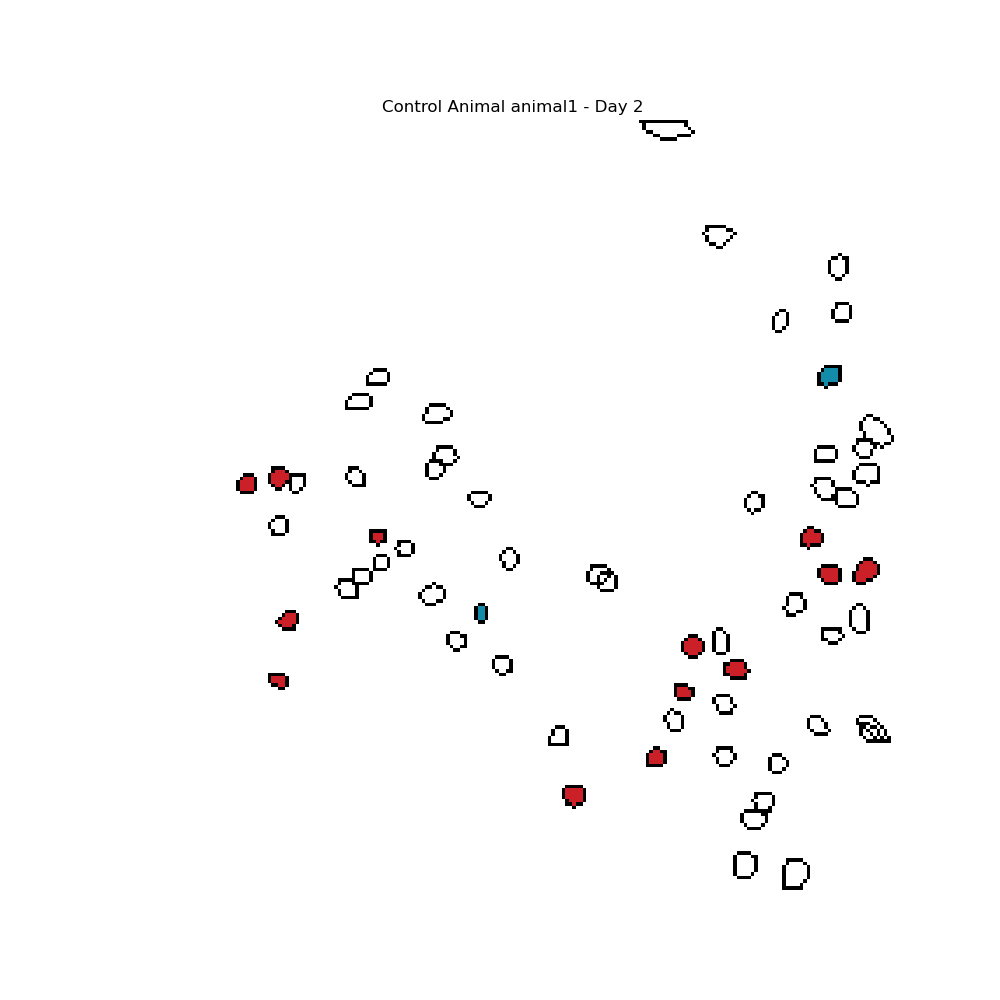


Control Animal animal1 - Day 2:
Partner neurons: 2
Novel neurons: 13
Total neurons: 62
Percent partner: 3.2%
Percent novel: 21.0%


In [46]:
plot_spatial_footprints(data_groups_d2, day2_14_auROCs_partner, 
                        day2_14_auROCs_novel, 
                        plotSpecific='control_animal1', 
                        save_dir=figDataSaveDir + '/imagingInhib_cells_supp')